# check over with methods section that it all correlates

In [1]:
#Irene (Rin) Mitsiades
#Rheinbay lab
#HOXB13 in breast cancer
#21/5/2024

In [2]:
#loading packages necessary to run notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.colors
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from SigProfilerMatrixGenerator.scripts import CNVMatrixGenerator as scna
from SigProfilerExtractor import sigpro as sig
from scipy.stats import chi2_contingency
from SigProfilerMatrixGenerator.scripts import SigProfilerMatrixGeneratorFunc as matGen
import os.path
import glob
import fnmatch
import os
import shutil
from pathlib import Path
import ternary
from scipy.stats import fisher_exact
from lifelines.utils import median_survival_times
import plotly.express as px
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from SigProfilerAssignment import Analyzer as Analyze

#displays plots in notebook
%matplotlib inline

#default figure settings (text size, spines, etc.)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams["figure.autolayout"] = True

def listdir(dirname, pattern="*"):
    return fnmatch.filter(os.listdir(dirname), pattern)

#DEFINITIONS
#0-1 copies = deletion
#2 copies = no change
#3-4 copies = gain
#5+ copies = high level amplification

In [3]:
#loading in TCGA data
#mRNA data from all cancers
pancancer_mRNA_data = pd.read_csv("Raw_data/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore')
#removing entrez ids
pancancer_mRNA_data.index = [w.split('|')[0] for w in pancancer_mRNA_data.index]
#clinical dataset with survival outcomes
pancancer_clinical_and_survival_data = pd.DataFrame(pd.read_excel("Raw_data/TCGA-CDR-SupplementalTableS1.xlsx", header=0, index_col=1)).apply(pd.to_numeric, errors='ignore')
#clinical dataset that includes receptor statuses for breast cancer
pancancer_followup_and_receptor_data = pd.read_csv("Raw_data/clinical_PANCAN_participant_with_followup.csv", sep = ",", header=0, index_col=1, low_memory=False).apply(pd.to_numeric, errors='ignore')

#general trimming of the TCGA data - shortening down names, checking the number of participants, etc.
#preparing the TCGA seg filee
mastercalls = pd.read_csv("Raw_data/TCGA_mastercalls.abs_segtabs.fixed.txt", sep='\t', index_col="Sample")
#shortening down the TCGA names
newnames = mastercalls.index.to_series().apply(lambda x: x[:12])
mastercalls.index = newnames

#mRNA 
#chopping samples into normal and tumor
sample_type = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x)  else 'normal' for x in pancancer_mRNA_data.columns.values]
zipped = pd.DataFrame(zip(list(pancancer_mRNA_data.columns.values), list(sample_type)), columns=['Sample_ID', 'Type'])
alltumors = zipped[zipped.Type=='tumor']['Sample_ID']
pancancer_mRNA_tumor_data = pancancer_mRNA_data[alltumors]

allnormals = zipped[zipped.Type=='normal']['Sample_ID']
pancancer_mRNA_normal_data= pancancer_mRNA_data[allnormals]
print('Total number of TCGA normal samples in PanCan mRNA dataset:', pancancer_mRNA_normal_data.shape[1])
print('Total number of TCGA tumor samples in PanCan mRNA dataset:', pancancer_mRNA_tumor_data.shape[1])

#shortening down the TCGA names
newindex = pancancer_mRNA_tumor_data.columns.to_series().apply(lambda x: x[:12])
pancancer_mRNA_tumor_data.columns = newindex



#picking out the breast cancer tumors
TCGA_BRCA_participants = pancancer_clinical_and_survival_data.loc[pancancer_clinical_and_survival_data.loc[:, "type"] == "BRCA"].index
TCGA_BRCA_mRNA_tumor_data = pancancer_mRNA_tumor_data.loc[:, np.in1d(pancancer_mRNA_tumor_data.columns, TCGA_BRCA_participants)]
TCGA_BRCA_followup_and_receptor_data = pancancer_followup_and_receptor_data.loc[np.in1d(pancancer_followup_and_receptor_data.index, TCGA_BRCA_participants)]
TCGA_BRCA_clinical_and_survival_data = pancancer_clinical_and_survival_data.loc[np.in1d(pancancer_clinical_and_survival_data.index, TCGA_BRCA_participants)]

print("")
print("After removing normals")
print('Total number of TCGA BRCA mRNA samples:', TCGA_BRCA_mRNA_tumor_data.shape[1])
print('Total number of TCGA BRCA clinical samples:', TCGA_BRCA_followup_and_receptor_data.shape[0])
print('Total number of TCGA BRCA survival samples:', TCGA_BRCA_clinical_and_survival_data.shape[0])

#keeping only participants that are listed in all of the datasets
shared_TCGA_BRCA_participants_across_datasets = mastercalls.index & TCGA_BRCA_mRNA_tumor_data.columns & TCGA_BRCA_followup_and_receptor_data.index & TCGA_BRCA_clinical_and_survival_data.index
TCGA_BRCA_mRNA_tumor_data = TCGA_BRCA_mRNA_tumor_data.loc[:, shared_TCGA_BRCA_participants_across_datasets]
TCGA_BRCA_followup_and_receptor_data = TCGA_BRCA_followup_and_receptor_data.loc[shared_TCGA_BRCA_participants_across_datasets]
TCGA_BRCA_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[shared_TCGA_BRCA_participants_across_datasets]

print("")
print("After picking out participants present in all sets")
print('Total number of TCGA BRCA mRNA samples:', TCGA_BRCA_mRNA_tumor_data.shape[1])
print('Total number of TCGA BRCA clinical samples:', TCGA_BRCA_followup_and_receptor_data.shape[0])
print('Total number of TCGA BRCA survival samples:', TCGA_BRCA_clinical_and_survival_data.shape[0])


#creating receptor subtype and HER2 status datasets for later use
#picking participants for groups
TCGA_BRCA_HERnegERpos_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Positive') & (TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Negative')].index
TCGA_BRCA_HERposERpos_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Positive') & (TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Positive')].index
TCGA_BRCA_HERposERneg_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Negative') & (TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Positive')].index
TCGA_BRCA_HERnegERneg_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Negative') & (TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Negative')].index
TCGA_BRCA_HERpos_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Positive')].index
TCGA_BRCA_HERneg_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Negative')].index
TCGA_BRCA_ERpos_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Positive')].index
TCGA_BRCA_ERneg_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Negative')].index

print('Total number of BRCA ERpos samples:', len(TCGA_BRCA_ERpos_participants))
print('Total number of BRCA ERneg samples:', len(TCGA_BRCA_ERneg_participants))

print('Total number of BRCA HERnegERpos samples:', len(TCGA_BRCA_HERnegERpos_participants))
print('Total number of BRCA HERposERpos samples:', len(TCGA_BRCA_HERposERpos_participants))
print('Total number of BRCA HERposERneg samples:', len(TCGA_BRCA_HERposERneg_participants))
print('Total number of BRCA HERnegERneg samples:', len(TCGA_BRCA_HERnegERneg_participants))

#picking participants out from the RNA dataset
TCGA_BRCA_HERnegERpos_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERnegERpos_participants]
TCGA_BRCA_HERposERpos_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERposERpos_participants]
TCGA_BRCA_HERposERneg_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERposERneg_participants]
TCGA_BRCA_HERnegERneg_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERnegERneg_participants]
TCGA_BRCA_ERpos_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_ERpos_participants]
TCGA_BRCA_ERneg_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_ERneg_participants]

#picking participants out from the survival dataset
TCGA_BRCA_HERnegERpos_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HERnegERpos_participants]
TCGA_BRCA_HERposERpos_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HERposERpos_participants]
TCGA_BRCA_HERposERneg_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HERposERneg_participants]
TCGA_BRCA_HERnegERneg_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HERnegERneg_participants]
TCGA_BRCA_ERpos_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_ERpos_participants]
TCGA_BRCA_ERneg_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_ERneg_participants]
TCGA_BRCA_ERpos_clinical_and_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.iloc[:, [24,25,30,31]]
TCGA_BRCA_ERneg_clinical_and_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.iloc[:, [24,25,30,31]]


#picking out the tumors from other cancer types
TCGA_UCEC_participants = pancancer_clinical_and_survival_data.loc[pancancer_clinical_and_survival_data.loc[:, "type"] == "UCEC"].index
TCGA_LUAD_participants = pancancer_clinical_and_survival_data.loc[pancancer_clinical_and_survival_data.loc[:, "type"] == "LUAD"].index
TCGA_COAD_participants = pancancer_clinical_and_survival_data.loc[pancancer_clinical_and_survival_data.loc[:, "type"] == "COAD"].index
TCGA_STAD_participants = pancancer_clinical_and_survival_data.loc[pancancer_clinical_and_survival_data.loc[:, "type"] == "STAD"].index


Total number of TCGA normal samples in PanCan mRNA dataset: 1364
Total number of TCGA tumor samples in PanCan mRNA dataset: 9705

After removing normals
Total number of TCGA BRCA mRNA samples: 1095
Total number of TCGA BRCA clinical samples: 1097
Total number of TCGA BRCA survival samples: 1097

After picking out participants present in all sets
Total number of TCGA BRCA mRNA samples: 1067
Total number of TCGA BRCA clinical samples: 1067
Total number of TCGA BRCA survival samples: 1067
Total number of BRCA ERpos samples: 786
Total number of BRCA ERneg samples: 232
Total number of BRCA HERnegERpos samples: 429
Total number of BRCA HERposERpos samples: 119
Total number of BRCA HERposERneg samples: 40
Total number of BRCA HERnegERneg samples: 121


In [4]:
#all figures in this paper are generated using the TCGA modal copy number (absolute number of copies). This code prepares the TCGA seg file to be read by bedtools.
#awk '$3>0 {print $1, int($2), int($3), int($4), int($5), int($9)}' OFS='\t' TCGA_mastercalls.abs_segtabs.fixed.txt | grep -v Sample | awk 'BEGIN{print "Sample\tChromosome\tStart\tEnd\tNum_Probes\tModal_Total_CN"}{print}' - > TCGA_mastercalls.abs_segtabs.fixed.IGV.seg 
#This code was run first to make the seg file IGV readable

#Genes of interest:
#17	46802125	46806111	HOXB13
#17	37844337	37873910	ERBB2
#17	41196312	41276132	BRCA1
#17	40351195	40428409	STAT5B
#17	43340486	43394386	MAP3K14
#17	38710021	38716646	CCR7
#17	40852293	40897058	EZH1
#17	45286428	45301045	MYL4

#adding these locations to their own dataframe
selected_gene_data = {'Gene name': ['HOXB13', 'ERBB2', 'BRCA1', 'STAT5B', 'MAP3K14', 'CCR7', 'EZH1', 'MYL4'], 'Chromosome': ['17', '17', '17', '17', '17', '17', '17', '17'], 'Start': [46802125, 37844337, 41196312, 40351195, 43340486, 38710021, 40852293, 45286428], 'End':  [46806111, 37873910, 41276132, 40428409, 43394386, 38716646, 40897058, 45301045]}
selected_locations = pd.DataFrame (selected_gene_data, columns = ['Chromosome','Start', 'End', 'Gene name'])
selected_locations.to_csv("selected_gene_locations.txt", sep='\t', index=False, header=False)

#picking breast cancer participants
BRCA_calls = mastercalls.loc[np.in1d(mastercalls.index, shared_TCGA_BRCA_participants_across_datasets)]
print("Number of BRCA cancer participants initally:", len(shared_TCGA_BRCA_participants_across_datasets))
print("Number of BRCA cancer participants that have clinical and modal copy number data:", len(set(BRCA_calls.index)))

#reset the index
BRCA_calls = BRCA_calls.reset_index()
BRCA_calls = BRCA_calls[~BRCA_calls['Chromosome'].isnull()]

#Dropping columns that won't be used: saves bedtools compute time
drop_columns = [4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]
BRCA_calls.drop(BRCA_calls.columns[drop_columns], axis=1, inplace=True)

#turning this into bedfile format to be inputted into bedtools
BRCA_calls = BRCA_calls[['Chromosome', 'Start', 'End', 'Sample', "Modal_Total_CN"]]
BRCA_calls['Chromosome'] = BRCA_calls['Chromosome'].astype(int)
BRCA_calls['Start'] = BRCA_calls['Start'].astype(int)
BRCA_calls['End'] = BRCA_calls['End'].astype(int)
BRCA_calls['Modal_Total_CN'] = BRCA_calls['Modal_Total_CN'].astype(float)
BRCA_calls.to_csv("BRCA_READY_TCGA_mastercalls.abs_segtabs.fixed.txt", sep='\t', index=False, header=False)

#now this will be run through bedtools
#bedtools command:
#bedtools intersect -a BRCA_READY_TCGA_mastercalls.abs_segtabs.fixed.txt -b selected_gene_locations.txt -wo > BRCA_TCGA_modalcopynumbercalls.txt


Number of BRCA cancer participants initally: 1067
Number of BRCA cancer participants that have clinical and modal copy number data: 1067


In [5]:
#picking UCEC cancer participants
UCEC_calls = mastercalls.loc[np.in1d(mastercalls.index, TCGA_UCEC_participants)]
print("Number of UCEC cancer participants initally:", len(TCGA_UCEC_participants))
print("Number of UCEC cancer participants that have clinical and modal copy number data:", len(set(UCEC_calls.index)))

#reset the index
UCEC_calls = UCEC_calls.reset_index()
UCEC_calls = UCEC_calls[~UCEC_calls['Chromosome'].isnull()]

#Dropping columns that won't be used: saves bedtools compute time
drop_columns = [4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]
UCEC_calls.drop(UCEC_calls.columns[drop_columns], axis=1, inplace=True)

#turning this into bedfile format to be inputted into bedtools
UCEC_calls = UCEC_calls[['Chromosome', 'Start', 'End', 'Sample', "Modal_Total_CN"]]
UCEC_calls['Chromosome'] = UCEC_calls['Chromosome'].astype(int)
UCEC_calls['Start'] = UCEC_calls['Start'].astype(int)
UCEC_calls['End'] = UCEC_calls['End'].astype(int)
UCEC_calls['Modal_Total_CN'] = UCEC_calls['Modal_Total_CN'].astype(float)
UCEC_calls.to_csv("UCEC_READY_TCGA_mastercalls.abs_segtabs.fixed.txt", sep='\t', index=False, header=False)

#now this will be run through bedtools
#bedtools command:
#bedtools intersect -a UCEC_READY_TCGA_mastercalls.abs_segtabs.fixed.txt -b selected_gene_locations.txt -wo > UCEC_TCGA_modalcopynumbercalls.txt


Number of UCEC cancer participants initally: 548
Number of UCEC cancer participants that have clinical and modal copy number data: 537


In [6]:
#picking COAD cancer participants
COAD_calls = mastercalls.loc[np.in1d(mastercalls.index, TCGA_COAD_participants)]
print("Number of COAD cancer participants initally:", len(TCGA_COAD_participants))
print("Number of COAD cancer participants that have clinical and modal copy number data:", len(set(COAD_calls.index)))

#reset the index
COAD_calls = COAD_calls.reset_index()
COAD_calls = COAD_calls[~COAD_calls['Chromosome'].isnull()]

#Dropping columns that won't be used: saves bedtools compute time
drop_columns = [4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]
COAD_calls.drop(COAD_calls.columns[drop_columns], axis=1, inplace=True)

#turning this into bedfile format to be inputted into bedtools
COAD_calls = COAD_calls[['Chromosome', 'Start', 'End', 'Sample', "Modal_Total_CN"]]
COAD_calls['Chromosome'] = COAD_calls['Chromosome'].astype(int)
COAD_calls['Start'] = COAD_calls['Start'].astype(int)
COAD_calls['End'] = COAD_calls['End'].astype(int)
COAD_calls['Modal_Total_CN'] = COAD_calls['Modal_Total_CN'].astype(float)
COAD_calls.to_csv("COAD_READY_TCGA_mastercalls.abs_segtabs.fixed.txt", sep='\t', index=False, header=False)

#now this will be run through bedtools
#bedtools command:
#bedtools intersect -a COAD_READY_TCGA_mastercalls.abs_segtabs.fixed.txt -b selected_gene_locations.txt -wo > COAD_TCGA_modalcopynumbercalls.txt


Number of COAD cancer participants initally: 459
Number of COAD cancer participants that have clinical and modal copy number data: 447


In [7]:
#picking LUAD cancer participants
LUAD_calls = mastercalls.loc[np.in1d(mastercalls.index, TCGA_LUAD_participants)]
print("Number of LUAD cancer participants initally:", len(TCGA_LUAD_participants))
print("Number of LUAD cancer participants that have clinical and modal copy number data:", len(set(LUAD_calls.index)))

#reset the index
LUAD_calls = LUAD_calls.reset_index()
LUAD_calls = LUAD_calls[~LUAD_calls['Chromosome'].isnull()]

#Dropping columns that won't be used: saves bedtools compute time
drop_columns = [4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]
LUAD_calls.drop(LUAD_calls.columns[drop_columns], axis=1, inplace=True)

#turning this into bedfile format to be inputted into bedtools
LUAD_calls = LUAD_calls[['Chromosome', 'Start', 'End', 'Sample', "Modal_Total_CN"]]
LUAD_calls['Chromosome'] = LUAD_calls['Chromosome'].astype(int)
LUAD_calls['Start'] = LUAD_calls['Start'].astype(int)
LUAD_calls['End'] = LUAD_calls['End'].astype(int)
LUAD_calls['Modal_Total_CN'] = LUAD_calls['Modal_Total_CN'].astype(float)
LUAD_calls.to_csv("LUAD_READY_TCGA_mastercalls.abs_segtabs.fixed.txt", sep='\t', index=False, header=False)

#now this will be run through bedtools
#bedtools command:
#bedtools intersect -a LUAD_READY_TCGA_mastercalls.abs_segtabs.fixed.txt -b selected_gene_locations.txt -wo > LUAD_TCGA_modalcopynumbercalls.txt


Number of LUAD cancer participants initally: 522
Number of LUAD cancer participants that have clinical and modal copy number data: 509


In [8]:
#picking STAD cancer participants
STAD_calls = mastercalls.loc[np.in1d(mastercalls.index, TCGA_STAD_participants)]
print("Number of STAD cancer participants initally:", len(TCGA_STAD_participants))
print("Number of STAD cancer participants that have clinical and modal copy number data:", len(set(STAD_calls.index)))

#reset the index
STAD_calls = STAD_calls.reset_index()
STAD_calls = STAD_calls[~STAD_calls['Chromosome'].isnull()]

#Dropping columns that won't be used: saves bedtools compute time
drop_columns = [4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]
STAD_calls.drop(STAD_calls.columns[drop_columns], axis=1, inplace=True)

#turning this into bedfile format to be inputted into bedtools
STAD_calls = STAD_calls[['Chromosome', 'Start', 'End', 'Sample', "Modal_Total_CN"]]
STAD_calls['Chromosome'] = STAD_calls['Chromosome'].astype(int)
STAD_calls['Start'] = STAD_calls['Start'].astype(int)
STAD_calls['End'] = STAD_calls['End'].astype(int)
STAD_calls['Modal_Total_CN'] = STAD_calls['Modal_Total_CN'].astype(float)
STAD_calls.to_csv("STAD_READY_TCGA_mastercalls.abs_segtabs.fixed.txt", sep='\t', index=False, header=False)

#now this will be run through bedtools
#bedtools command:
#bedtools intersect -a STAD_READY_TCGA_mastercalls.abs_segtabs.fixed.txt -b selected_gene_locations.txt -wo > STAD_TCGA_modalcopynumbercalls.txt


Number of STAD cancer participants initally: 443
Number of STAD cancer participants that have clinical and modal copy number data: 438


In [9]:
#reading from outputted text file of modal copy number calls
TCGA_BRCA_modalCNcalls = pd.read_csv("Raw_data/BRCA_TCGA_modalcopynumbercalls.txt", sep = "\t", index_col = 0, names = ["Chromosome", "Start location of CN segment", "End location of CN segment", "participant", "Copy number", "Chromosome_again", "Start location of gene", "End location of gene", "Gene", "Gene length"])
#removing unecessary columns
TCGA_BRCA_modalCNcalls = TCGA_BRCA_modalCNcalls.drop(["Gene length", "Chromosome_again", "Start location of gene", "End location of gene"], axis = 1)
TCGA_BRCA_modalCNcalls["Segment_length"] = TCGA_BRCA_modalCNcalls["End location of CN segment"] - TCGA_BRCA_modalCNcalls["Start location of CN segment"]
TCGA_BRCA_modalCNcalls.index = TCGA_BRCA_modalCNcalls.loc[:, "participant"]
TCGA_BRCA_modalCNcalls = TCGA_BRCA_modalCNcalls[['Copy number', 'Gene', 'Segment_length']]

print("Number of TCGA BRCA participants that have modal copy number calls:", len(set(TCGA_BRCA_modalCNcalls.index)))
#making individual dataframes for each gene calls

gene_list = list(set(TCGA_BRCA_modalCNcalls["Gene"]))
dataframe_list = []
for x in list(set(TCGA_BRCA_modalCNcalls["Gene"])):
    dataframe_list.append('TCGA_BRCA_callsonly' + str(x))

Dictionary = {}
 
for i in range(0, len(dataframe_list)):
    Dictionary[dataframe_list[i]] = pd.DataFrame()
    Dictionary[dataframe_list[i]] = pd.DataFrame(data = TCGA_BRCA_modalCNcalls.loc[TCGA_BRCA_modalCNcalls.loc[:, "Gene"] == gene_list[i]])
    #removing duplicate values by taking the average
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]].groupby('participant').mean().reset_index()
    Dictionary[dataframe_list[i]].index = Dictionary[dataframe_list[i]]["participant"]
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]][['Copy number', 'Segment_length']]
    Dictionary[dataframe_list[i]]["Gene name"] = gene_list[i]
    #annotating
    Dictionary[dataframe_list[i]].loc[:, "ER status"] = "N/A"
    Dictionary[dataframe_list[i]].loc[np.in1d(Dictionary[dataframe_list[i]].index, TCGA_BRCA_ERpos_participants), "ER status"] = "Pos"
    Dictionary[dataframe_list[i]].loc[np.in1d(Dictionary[dataframe_list[i]].index, TCGA_BRCA_ERneg_participants), "ER status"] = "Neg"
    Dictionary[dataframe_list[i]].loc[:, "HER2 status"] = "N/A"
    Dictionary[dataframe_list[i]].loc[np.in1d(Dictionary[dataframe_list[i]].index, TCGA_BRCA_HERpos_participants), "HER2 status"] = "Pos"
    Dictionary[dataframe_list[i]].loc[np.in1d(Dictionary[dataframe_list[i]].index, TCGA_BRCA_HERneg_participants), "HER2 status"] = "Neg"
    Dictionary[dataframe_list[i]].loc[:, "HOXB13 mRNA"] = TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]
    print("Number of TCGA participants that have modal copy number calls for this gene:", gene_list[i], len(Dictionary[dataframe_list[i]].index))
    #putting into individual dataframes
    for name, df in Dictionary.items():
        globals()[name] = df
    


Number of TCGA BRCA participants that have modal copy number calls: 1040
Number of TCGA participants that have modal copy number calls for this gene: STAT5B 1040
Number of TCGA participants that have modal copy number calls for this gene: ERBB2 1008
Number of TCGA participants that have modal copy number calls for this gene: CCR7 1039
Number of TCGA participants that have modal copy number calls for this gene: HOXB13 1039
Number of TCGA participants that have modal copy number calls for this gene: BRCA1 1040
Number of TCGA participants that have modal copy number calls for this gene: MAP3K14 1040
Number of TCGA participants that have modal copy number calls for this gene: EZH1 1040
Number of TCGA participants that have modal copy number calls for this gene: MYL4 1040


In [10]:
#reading from outputted text file of modal copy number calls
TCGA_UCEC_modalCNcalls = pd.read_csv("UCEC_TCGA_modalcopynumbercalls.txt", sep = "\t", index_col = 0, names = ["Chromosome", "Start location of CN segment", "End location of CN segment", "participant", "Copy number", "Chromosome_again", "Start location of gene", "End location of gene", "Gene", "Gene length"])
#removing unecessary columns
TCGA_UCEC_modalCNcalls = TCGA_UCEC_modalCNcalls.drop(["Gene length", "Chromosome_again", "Start location of gene", "End location of gene"], axis = 1)
TCGA_UCEC_modalCNcalls["Segment_length"] = TCGA_UCEC_modalCNcalls["End location of CN segment"] - TCGA_UCEC_modalCNcalls["Start location of CN segment"]
TCGA_UCEC_modalCNcalls.index = TCGA_UCEC_modalCNcalls.loc[:, "participant"]
TCGA_UCEC_modalCNcalls = TCGA_UCEC_modalCNcalls[['Copy number', 'Gene', 'Segment_length']]

print("Number of TCGA UCEC participants that have modal copy number calls:", len(set(TCGA_UCEC_modalCNcalls.index)))
#making individual dataframes for each gene calls

gene_list = list(set(TCGA_UCEC_modalCNcalls["Gene"]))
dataframe_list = []
for x in list(set(TCGA_UCEC_modalCNcalls["Gene"])):
    dataframe_list.append('TCGA_UCEC_callsonly' + str(x))

Dictionary = {}
 
for i in range(0, len(dataframe_list)):
    Dictionary[dataframe_list[i]] = pd.DataFrame()
    Dictionary[dataframe_list[i]] = pd.DataFrame(data = TCGA_UCEC_modalCNcalls.loc[TCGA_UCEC_modalCNcalls.loc[:, "Gene"] == gene_list[i]])
    #removing duplicate values by taking the average
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]].groupby('participant').mean().reset_index()
    Dictionary[dataframe_list[i]].index = Dictionary[dataframe_list[i]]["participant"]
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]][['Copy number', 'Segment_length']]
    Dictionary[dataframe_list[i]]["Gene name"] = gene_list[i]
    print("Number of TCGA participants that have modal copy number calls for this gene:", gene_list[i], len(Dictionary[dataframe_list[i]].index))
    #putting into individual dataframes
    for name, df in Dictionary.items():
        globals()[name] = df
    


Number of TCGA UCEC participants that have modal copy number calls: 536
Number of TCGA participants that have modal copy number calls for this gene: STAT5B 536
Number of TCGA participants that have modal copy number calls for this gene: ERBB2 531
Number of TCGA participants that have modal copy number calls for this gene: CCR7 536
Number of TCGA participants that have modal copy number calls for this gene: HOXB13 536
Number of TCGA participants that have modal copy number calls for this gene: BRCA1 536
Number of TCGA participants that have modal copy number calls for this gene: MAP3K14 536
Number of TCGA participants that have modal copy number calls for this gene: EZH1 536
Number of TCGA participants that have modal copy number calls for this gene: MYL4 536


In [11]:
#reading from outputted text file of modal copy number calls
TCGA_COAD_modalCNcalls = pd.read_csv("COAD_TCGA_modalcopynumbercalls.txt", sep = "\t", index_col = 0, names = ["Chromosome", "Start location of CN segment", "End location of CN segment", "participant", "Copy number", "Chromosome_again", "Start location of gene", "End location of gene", "Gene", "Gene length"])
#removing unecessary columns
TCGA_COAD_modalCNcalls = TCGA_COAD_modalCNcalls.drop(["Gene length", "Chromosome_again", "Start location of gene", "End location of gene"], axis = 1)
TCGA_COAD_modalCNcalls["Segment_length"] = TCGA_COAD_modalCNcalls["End location of CN segment"] - TCGA_COAD_modalCNcalls["Start location of CN segment"]
TCGA_COAD_modalCNcalls.index = TCGA_COAD_modalCNcalls.loc[:, "participant"]
TCGA_COAD_modalCNcalls = TCGA_COAD_modalCNcalls[['Copy number', 'Gene', 'Segment_length']]

print("Number of TCGA COAD participants that have modal copy number calls:", len(set(TCGA_COAD_modalCNcalls.index)))
#making individual dataframes for each gene calls

gene_list = list(set(TCGA_COAD_modalCNcalls["Gene"]))
dataframe_list = []
for x in list(set(TCGA_COAD_modalCNcalls["Gene"])):
    dataframe_list.append('TCGA_COAD_callsonly' + str(x))

Dictionary = {}
 
for i in range(0, len(dataframe_list)):
    Dictionary[dataframe_list[i]] = pd.DataFrame()
    Dictionary[dataframe_list[i]] = pd.DataFrame(data = TCGA_COAD_modalCNcalls.loc[TCGA_COAD_modalCNcalls.loc[:, "Gene"] == gene_list[i]])
    #removing duplicate values by taking the average
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]].groupby('participant').mean().reset_index()
    Dictionary[dataframe_list[i]].index = Dictionary[dataframe_list[i]]["participant"]
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]][['Copy number', 'Segment_length']]
    Dictionary[dataframe_list[i]]["Gene name"] = gene_list[i]
    print("Number of TCGA participants that have modal copy number calls for this gene:", gene_list[i], len(Dictionary[dataframe_list[i]].index))
    #putting into individual dataframes
    for name, df in Dictionary.items():
        globals()[name] = df
    

Number of TCGA COAD participants that have modal copy number calls: 444
Number of TCGA participants that have modal copy number calls for this gene: STAT5B 444
Number of TCGA participants that have modal copy number calls for this gene: ERBB2 442
Number of TCGA participants that have modal copy number calls for this gene: CCR7 443
Number of TCGA participants that have modal copy number calls for this gene: HOXB13 444
Number of TCGA participants that have modal copy number calls for this gene: BRCA1 444
Number of TCGA participants that have modal copy number calls for this gene: MAP3K14 444
Number of TCGA participants that have modal copy number calls for this gene: EZH1 444
Number of TCGA participants that have modal copy number calls for this gene: MYL4 444


In [12]:
#reading from outputted text file of modal copy number calls
TCGA_LUAD_modalCNcalls = pd.read_csv("LUAD_TCGA_modalcopynumbercalls.txt", sep = "\t", index_col = 0, names = ["Chromosome", "Start location of CN segment", "End location of CN segment", "participant", "Copy number", "Chromosome_again", "Start location of gene", "End location of gene", "Gene", "Gene length"])
#removing unecessary columns
TCGA_LUAD_modalCNcalls = TCGA_LUAD_modalCNcalls.drop(["Gene length", "Chromosome_again", "Start location of gene", "End location of gene"], axis = 1)
TCGA_LUAD_modalCNcalls["Segment_length"] = TCGA_LUAD_modalCNcalls["End location of CN segment"] - TCGA_LUAD_modalCNcalls["Start location of CN segment"]
TCGA_LUAD_modalCNcalls.index = TCGA_LUAD_modalCNcalls.loc[:, "participant"]
TCGA_LUAD_modalCNcalls = TCGA_LUAD_modalCNcalls[['Copy number', 'Gene', 'Segment_length']]

print("Number of TCGA LUAD participants that have modal copy number calls:", len(set(TCGA_LUAD_modalCNcalls.index)))
#making individual dataframes for each gene calls

gene_list = list(set(TCGA_LUAD_modalCNcalls["Gene"]))
dataframe_list = []
for x in list(set(TCGA_LUAD_modalCNcalls["Gene"])):
    dataframe_list.append('TCGA_LUAD_callsonly' + str(x))

Dictionary = {}
 
for i in range(0, len(dataframe_list)):
    Dictionary[dataframe_list[i]] = pd.DataFrame()
    Dictionary[dataframe_list[i]] = pd.DataFrame(data = TCGA_LUAD_modalCNcalls.loc[TCGA_LUAD_modalCNcalls.loc[:, "Gene"] == gene_list[i]])
    #removing duplicate values by taking the average
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]].groupby('participant').mean().reset_index()
    Dictionary[dataframe_list[i]].index = Dictionary[dataframe_list[i]]["participant"]
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]][['Copy number', 'Segment_length']]
    Dictionary[dataframe_list[i]]["Gene name"] = gene_list[i]
    print("Number of TCGA participants that have modal copy number calls for this gene:", gene_list[i], len(Dictionary[dataframe_list[i]].index))
    #putting into individual dataframes
    for name, df in Dictionary.items():
        globals()[name] = df
    

Number of TCGA LUAD participants that have modal copy number calls: 507
Number of TCGA participants that have modal copy number calls for this gene: STAT5B 507
Number of TCGA participants that have modal copy number calls for this gene: ERBB2 505
Number of TCGA participants that have modal copy number calls for this gene: CCR7 507
Number of TCGA participants that have modal copy number calls for this gene: HOXB13 507
Number of TCGA participants that have modal copy number calls for this gene: BRCA1 507
Number of TCGA participants that have modal copy number calls for this gene: MAP3K14 507
Number of TCGA participants that have modal copy number calls for this gene: EZH1 507
Number of TCGA participants that have modal copy number calls for this gene: MYL4 507


In [13]:
#reading from outputted text file of modal copy number calls
TCGA_STAD_modalCNcalls = pd.read_csv("STAD_TCGA_modalcopynumbercalls.txt", sep = "\t", index_col = 0, names = ["Chromosome", "Start location of CN segment", "End location of CN segment", "participant", "Copy number", "Chromosome_again", "Start location of gene", "End location of gene", "Gene", "Gene length"])
#removing unecessary columns
TCGA_STAD_modalCNcalls = TCGA_STAD_modalCNcalls.drop(["Gene length", "Chromosome_again", "Start location of gene", "End location of gene"], axis = 1)
TCGA_STAD_modalCNcalls["Segment_length"] = TCGA_STAD_modalCNcalls["End location of CN segment"] - TCGA_STAD_modalCNcalls["Start location of CN segment"]
TCGA_STAD_modalCNcalls.index = TCGA_STAD_modalCNcalls.loc[:, "participant"]
TCGA_STAD_modalCNcalls = TCGA_STAD_modalCNcalls[['Copy number', 'Gene', 'Segment_length']]

print("Number of TCGA STAD participants that have modal copy number calls:", len(set(TCGA_STAD_modalCNcalls.index)))
#making individual dataframes for each gene calls

gene_list = list(set(TCGA_STAD_modalCNcalls["Gene"]))
dataframe_list = []
for x in list(set(TCGA_STAD_modalCNcalls["Gene"])):
    dataframe_list.append('TCGA_STAD_callsonly' + str(x))

Dictionary = {}
 
for i in range(0, len(dataframe_list)):
    Dictionary[dataframe_list[i]] = pd.DataFrame()
    Dictionary[dataframe_list[i]] = pd.DataFrame(data = TCGA_STAD_modalCNcalls.loc[TCGA_STAD_modalCNcalls.loc[:, "Gene"] == gene_list[i]])
    #removing duplicate values by taking the average
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]].groupby('participant').mean().reset_index()
    Dictionary[dataframe_list[i]].index = Dictionary[dataframe_list[i]]["participant"]
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]][['Copy number', 'Segment_length']]
    Dictionary[dataframe_list[i]]["Gene name"] = gene_list[i]
    print("Number of TCGA participants that have modal copy number calls for this gene:", gene_list[i], len(Dictionary[dataframe_list[i]].index))
    #putting into individual dataframes
    for name, df in Dictionary.items():
        globals()[name] = df
    

Number of TCGA STAD participants that have modal copy number calls: 429
Number of TCGA participants that have modal copy number calls for this gene: STAT5B 429
Number of TCGA participants that have modal copy number calls for this gene: ERBB2 416
Number of TCGA participants that have modal copy number calls for this gene: CCR7 426
Number of TCGA participants that have modal copy number calls for this gene: HOXB13 429
Number of TCGA participants that have modal copy number calls for this gene: BRCA1 429
Number of TCGA participants that have modal copy number calls for this gene: MAP3K14 429
Number of TCGA participants that have modal copy number calls for this gene: EZH1 429
Number of TCGA participants that have modal copy number calls for this gene: MYL4 429


In [14]:
#loading in CCLE data
CCLE_allcelllines_CN_data = pd.read_csv("Raw_data/CCLE_gene_cn.csv", sep=',', header=0, index_col=0, low_memory=False)
CCLE_allcelllines_clinicalinfo = pd.read_csv("Raw_data/CCLE_Model.csv", sep=',', header=0, index_col=0, low_memory=False)

#picking gap, cogain, and erbb2 only participants based on GISTIC output
pancancer_gistic_output_copynumber_data = pd.read_csv("Raw_data/all_thresholded.by_genes_whitelisted.tsv", sep = "\t", header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore')
#chopping samples into normal and tumor
sample_type = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x)  else 'normal' for x in pancancer_gistic_output_copynumber_data.columns.values]
zipped = pd.DataFrame(zip(list(pancancer_gistic_output_copynumber_data.columns.values), list(sample_type)), columns=['Sample_ID', 'Type'])
alltumors = zipped[zipped.Type=='tumor']['Sample_ID']
pancancer_tumor_copynumber_data = pancancer_gistic_output_copynumber_data[alltumors]

allnormals = zipped[zipped.Type=='normal']['Sample_ID']
pancancer_normal_copynumber_data = pancancer_gistic_output_copynumber_data[allnormals]
print('Total number of TCGA normal samples in PanCan GISTIC2.0 copy number dataset:', pancancer_normal_copynumber_data.shape[1])
print('Total number of TCGA tumor samples in PanCan GISTIC2.0 copy number dataset:', pancancer_tumor_copynumber_data.shape[1])

#shortening down the TCGA names
newindex = pancancer_tumor_copynumber_data.columns.to_series().apply(lambda x: x[:12])
pancancer_tumor_copynumber_data.columns = newindex
TCGA_BRCA_tumor_copynumber_data = pancancer_tumor_copynumber_data.loc[:, np.in1d(pancancer_tumor_copynumber_data.columns, shared_TCGA_BRCA_participants_across_datasets)]

TCGA_BRCA_HER_gained_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns
TCGA_BRCA_HOX_gained_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns
TCGA_BRCA_HER_nongained_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 1].columns
TCGA_BRCA_HOX_nongained_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 1].columns
TCGA_BRCA_HOX_amped_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 1].columns


TCGA_BRCA_gap_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['BRCA1'] < 0].columns
pd.DataFrame(TCGA_BRCA_gap_participants).to_csv("Gap_participant_list.txt", header = False, index = False)
TCGA_BRCA_ERBB2only_participants = TCGA_BRCA_HER_gained_participants.intersection(TCGA_BRCA_HOX_nongained_participants)
pd.DataFrame(TCGA_BRCA_ERBB2only_participants).to_csv("ERBB2only_participant_list.txt", header = False, index = False)
TCGA_BRCA_co_gained_participants = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['BRCA1'] > -1].columns)
pd.DataFrame(TCGA_BRCA_co_gained_participants).to_csv("cogain_participant_list.txt", header = False, index = False)
TCGA_BRCA_HOXB13only_participants = TCGA_BRCA_HOX_gained_participants.intersection(TCGA_BRCA_HER_nongained_participants)
pd.DataFrame(TCGA_BRCA_HOXB13only_participants).to_csv("HOXB13only_participant_list.txt", header = False, index = False)

#making sure there are no participants included in multiple groups (sanity check)
print(set(TCGA_BRCA_gap_participants) & set(TCGA_BRCA_ERBB2only_participants) )
print(set(TCGA_BRCA_gap_participants) & set(TCGA_BRCA_co_gained_participants) )
print(set(TCGA_BRCA_co_gained_participants) & set(TCGA_BRCA_ERBB2only_participants) )


print('Total number of BRCA HER2 gained samples:', len(TCGA_BRCA_HER_gained_participants))
print('Total number of BRCA HER2 ONLY gained samples:', len(TCGA_BRCA_ERBB2only_participants))
print('Total number of BRCA HOXB13 ONLY gained samples:', len(TCGA_BRCA_HOXB13only_participants))
print('Total number of BRCA HOXB13 gained samples:', len(TCGA_BRCA_HOX_gained_participants))
print('Total number of BRCA cogained samples:', len(TCGA_BRCA_co_gained_participants))
print('Total number of BRCA gap samples (gain version):', len(TCGA_BRCA_gap_participants))



Total number of TCGA normal samples in PanCan GISTIC2.0 copy number dataset: 561
Total number of TCGA tumor samples in PanCan GISTIC2.0 copy number dataset: 10154
set()
set()
set()
Total number of BRCA HER2 gained samples: 327
Total number of BRCA HER2 ONLY gained samples: 87
Total number of BRCA HOXB13 ONLY gained samples: 67
Total number of BRCA HOXB13 gained samples: 307
Total number of BRCA cogained samples: 192
Total number of BRCA gap samples (gain version): 48


In [15]:
#loading in METABRIC data
METABRIC_clinical_data = pd.read_csv("Raw_data/METABRIC_data_clinical_sample.txt", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_OverallSurival = pd.read_csv("Raw_data/METABRIC_KM_Plot__Overall_Survival__(months).txt", sep='\t' , header=0, index_col="Patient ID", low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_RelapseFreeSurival = pd.read_csv("Raw_data/METABRIC_KM_Plot__Relapse_Free__Survival_(months).txt", sep='\t' , header=0, index_col="Patient ID", low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_mRNA_zscores = pd.read_csv("Raw_data/METABRIC_data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_clinical_data = pd.read_csv("Raw_data/METABRIC_data_clinical_sample.txt", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
#dropping columns with repeated info
METABRIC_clinical_data = METABRIC_clinical_data.drop(["#Identifier to uniquely specify a patient.", "#STRING", "#1", "PATIENT_ID"], axis = 0)
METABRIC_clinical_data.index.name = "PATIENT_ID"

#removing the Entrez IDs since they are not used
METABRIC_mRNA_zscores = METABRIC_mRNA_zscores.drop("Entrez_Gene_Id", axis=1)

#information from METABRIC:
#Copy-number alterations from DNA copy. Calls made after normal contamination correction and CNV removal using thresholds.
#Values: -2 = homozygous deletion; -1 = hemizygous deletion; 0 = neutral / no change; 1 = gain; 2 = high level amplification
METABRIC_copynumber_data = pd.read_csv("Raw_data/METABRIC_data_cna.txt", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_copynumber_data = METABRIC_copynumber_data.drop("Entrez_Gene_Id", axis = 1)

#Trimming names from METABRIC data
METABRIC_RelapseFreeSurival.loc[:, "RFS_STATUS"] = [w.split(':')[0] for w in METABRIC_RelapseFreeSurival.loc[:, "RFS_STATUS"]]
METABRIC_OverallSurival.loc[:, "OS_STATUS"] = [w.split(':')[0] for w in METABRIC_OverallSurival.loc[:, "OS_STATUS"]]

#converting months to days. Standard convention is 1 month = 30.4166667 days
METABRIC_OverallSurival["OS_DAYS"] = METABRIC_OverallSurival["OS_MONTHS"].apply(lambda x: x*30.4166667)
METABRIC_RelapseFreeSurival["RFS_DAYS"] = METABRIC_RelapseFreeSurival["RFS_MONTHS"].apply(lambda x: x*30.4166667)
#dropping months column 
METABRIC_OverallSurival = METABRIC_OverallSurival.drop(["OS_MONTHS"], axis = 1)
METABRIC_RelapseFreeSurival = METABRIC_RelapseFreeSurival.drop(["RFS_MONTHS"], axis = 1)

#Picking out ER and HER2 status participants
METABRIC_ERpos_participants = METABRIC_clinical_data.loc[METABRIC_clinical_data.loc[:, "ER Status"] == "Positive"].index
METABRIC_ERneg_participants = METABRIC_clinical_data.loc[METABRIC_clinical_data.loc[:, "ER Status"] == "Negative"].index
METABRIC_HER2pos_participants = METABRIC_clinical_data.loc[METABRIC_clinical_data.loc[:, "HER2 Status"] == "Positive"].index
METABRIC_HER2neg_participants = METABRIC_clinical_data.loc[METABRIC_clinical_data.loc[:, "HER2 Status"] == "Negative"].index
METABRIC_HER2posERpos_participants = list(set(METABRIC_ERpos_participants) & set(METABRIC_HER2pos_participants))
METABRIC_HER2posERneg_participants = list(set(METABRIC_ERneg_participants) & set(METABRIC_HER2pos_participants))
METABRIC_HER2negERpos_participants = list(set(METABRIC_ERpos_participants) & set(METABRIC_HER2neg_participants))
METABRIC_HER2negERneg_participants = list(set(METABRIC_ERneg_participants) & set(METABRIC_HER2neg_participants))

#printing number of samples
print("Number of METABRIC HER2+ participants:", len(METABRIC_HER2pos_participants))
print("Number of METABRIC HER2- participants:", len(METABRIC_HER2neg_participants))
print("Number of METABRIC ER+ participants:", len(METABRIC_ERpos_participants))
print("Number of METABRIC ER- participants:", len(METABRIC_ERneg_participants))
print("Number of METABRIC HER2+ER+ participants:", len(METABRIC_HER2posERpos_participants))
print("Number of METABRIC HER2+ER- participants:", len(METABRIC_HER2posERneg_participants))
print("Number of METABRIC HER2-ER+ participants:", len(METABRIC_HER2negERpos_participants))
print("Number of METABRIC HER2-ER- participants:", len(METABRIC_HER2negERneg_participants))

#Labelling participants with IHC status
METABRIC_ERpos_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_ERpos_participants)]
METABRIC_ERneg_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_ERneg_participants)]
METABRIC_HER2pos_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2pos_participants)]
METABRIC_HER2neg_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2neg_participants)]
METABRIC_HER2posERpos_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2posERpos_participants)]
METABRIC_HER2posERneg_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2posERneg_participants)]
METABRIC_HER2negERpos_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2negERpos_participants)]
METABRIC_HER2negERneg_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2negERneg_participants)]

#picking out METABRIC participants
METABRIC_ERBB2gained_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["ERBB2"] > 0].columns
METABRIC_HOXB13gained_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["HOXB13"] > 0].columns
METABRIC_gap_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["ERBB2"] > 0].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["HOXB13"] > 0].columns  & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["BRCA1"] < 0].columns
METABRIC_ERBB2amped_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["ERBB2"] > 0].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["HOXB13"] < 1].columns  & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["BRCA1"] > -1].columns
METABRIC_coamp_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["ERBB2"] > 0].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["HOXB13"] > 0].columns  & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["BRCA1"] > -1].columns

#concatenating both OS and RFS
METABRIC_survival_df = pd.concat([METABRIC_OverallSurival, METABRIC_RelapseFreeSurival], axis = 1).drop(["Study ID"], axis = 1).dropna()


Number of METABRIC HER2+ participants: 175
Number of METABRIC HER2- participants: 1231
Number of METABRIC ER+ participants: 1077
Number of METABRIC ER- participants: 329
Number of METABRIC HER2+ER+ participants: 80
Number of METABRIC HER2+ER- participants: 95
Number of METABRIC HER2-ER+ participants: 997
Number of METABRIC HER2-ER- participants: 234


In [16]:
#Code to prepare survival analyses data
#Combining TCGA and METABRIC data for a higher n

#making survival dataframes
#METABRIC
METABRIC_ERpos_gap_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERpos_participants) & (METABRIC_gap_participants)))]
METABRIC_ERpos_gap_survival_data["Status"] = "Gap"
METABRIC_ERneg_gap_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERneg_participants) & (METABRIC_gap_participants)))]
METABRIC_ERneg_gap_survival_data["Status"] = "Gap"

METABRIC_ERpos_erbb2only_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERpos_participants) & (METABRIC_ERBB2amped_participants)))]
METABRIC_ERpos_erbb2only_survival_data["Status"] = "ERBB2 only gained"
METABRIC_ERneg_erbb2only_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERneg_participants) & (METABRIC_ERBB2amped_participants)))]
METABRIC_ERneg_erbb2only_survival_data["Status"] = "ERBB2 only gained"

METABRIC_ERpos_cogain_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERpos_participants) & (METABRIC_coamp_participants)))]
METABRIC_ERpos_cogain_survival_data["Status"] = "co-gained"
METABRIC_ERneg_cogain_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERneg_participants) & (METABRIC_coamp_participants)))]
METABRIC_ERneg_cogain_survival_data["Status"] = "co-gained"


#TCGA
TCGA_ERpos_gap_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERpos_clinical_and_survival_data.index, list(TCGA_BRCA_gap_participants))]
TCGA_ERpos_gap_survival_data["Status"] = "Gap"
TCGA_ERneg_gap_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERneg_clinical_and_survival_data.index, list(TCGA_BRCA_gap_participants))]
TCGA_ERneg_gap_survival_data["Status"] = "Gap"

TCGA_ERpos_erbb2only_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERpos_clinical_and_survival_data.index, TCGA_BRCA_ERBB2only_participants)]
TCGA_ERpos_erbb2only_survival_data["Status"] = "ERBB2 only gained"
TCGA_ERneg_erbb2only_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERneg_clinical_and_survival_data.index, TCGA_BRCA_ERBB2only_participants)]
TCGA_ERneg_erbb2only_survival_data["Status"] = "ERBB2 only gained"

TCGA_ERpos_cogain_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERpos_clinical_and_survival_data.index, list(TCGA_BRCA_co_gained_participants))]
TCGA_ERpos_cogain_survival_data["Status"] = "co-gained"
TCGA_ERneg_cogain_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERneg_clinical_and_survival_data.index, list(TCGA_BRCA_co_gained_participants))]
TCGA_ERneg_cogain_survival_data["Status"] = "co-gained"


#QC
print("Number of METABRIC ER+ Gap participants:", len(METABRIC_ERpos_gap_survival_data.index))
print("Number of METABRIC ER- Gap participants:", len(METABRIC_ERneg_gap_survival_data.index))
print("Number of TCGA ER+ Gap participants:", len(TCGA_ERpos_gap_survival_data.index))
print("Number of TCGA ER- Gap participants:", len(TCGA_ERneg_gap_survival_data.index))

print("Number of METABRIC ER+ ERBB2 only amped participants:", len(METABRIC_ERpos_erbb2only_survival_data.index))
print("Number of METABRIC ER- ERBB2 only amped participants:", len(METABRIC_ERneg_erbb2only_survival_data.index))
print("Number of TCGA ER+ ERBB2 only amped participants:", len(TCGA_ERpos_erbb2only_survival_data.index))
print("Number of TCGA ER- ERBB2 only amped participants:", len(TCGA_ERneg_erbb2only_survival_data.index))

print("Number of METABRIC ER+ cogain participants:", len(METABRIC_ERpos_cogain_survival_data.index))
print("Number of METABRIC ER- cogain participants:", len(METABRIC_ERneg_cogain_survival_data.index))
print("Number of TCGA ER+ cogain participants:", len(TCGA_ERpos_cogain_survival_data.index))
print("Number of TCGA ER- cogain participants:", len(TCGA_ERneg_cogain_survival_data.index))


#concatenating
METABRIC_ERpos_concatsurvival = pd.concat([METABRIC_ERpos_erbb2only_survival_data, METABRIC_ERpos_gap_survival_data, METABRIC_ERpos_cogain_survival_data]).apply(pd.to_numeric, errors='ignore')
METABRIC_ERneg_concatsurvival = pd.concat([METABRIC_ERneg_erbb2only_survival_data, METABRIC_ERneg_gap_survival_data, METABRIC_ERneg_cogain_survival_data]).apply(pd.to_numeric, errors='ignore')
TCGA_ERpos_concatsurvival = pd.concat([TCGA_ERpos_erbb2only_survival_data, TCGA_ERpos_gap_survival_data, TCGA_ERpos_cogain_survival_data]).apply(pd.to_numeric, errors='ignore')
TCGA_ERneg_concatsurvival = pd.concat([TCGA_ERneg_erbb2only_survival_data, TCGA_ERneg_gap_survival_data, TCGA_ERneg_cogain_survival_data]).apply(pd.to_numeric, errors='ignore')
METABRIC_ERpos_concatsurvival.columns = TCGA_ERpos_concatsurvival.columns
METABRIC_ERneg_concatsurvival.columns = TCGA_ERneg_concatsurvival.columns

#final survival dataframes
ERpos_concatsurvival = pd.concat([METABRIC_ERpos_concatsurvival, TCGA_ERpos_concatsurvival], axis = 0).apply(pd.to_numeric, errors='ignore')
ERneg_concatsurvival = pd.concat([METABRIC_ERneg_concatsurvival, TCGA_ERneg_concatsurvival], axis = 0).apply(pd.to_numeric, errors='ignore')
all_concatsurvival = pd.concat([ERpos_concatsurvival, ERneg_concatsurvival], axis = 0).apply(pd.to_numeric, errors='ignore')

Number of METABRIC ER+ Gap participants: 20
Number of METABRIC ER- Gap participants: 19
Number of TCGA ER+ Gap participants: 30
Number of TCGA ER- Gap participants: 15
Number of METABRIC ER+ ERBB2 only amped participants: 56
Number of METABRIC ER- ERBB2 only amped participants: 43
Number of TCGA ER+ ERBB2 only amped participants: 50
Number of TCGA ER- ERBB2 only amped participants: 36
Number of METABRIC ER+ cogain participants: 105
Number of METABRIC ER- cogain participants: 6
Number of TCGA ER+ cogain participants: 155
Number of TCGA ER- cogain participants: 23


In [17]:
#This is where TCGA sample spreadsheet of all BRCA participant information is created

manuscript_spreadsheet = pd.DataFrame(index = shared_TCGA_BRCA_participants_across_datasets)
manuscript_spreadsheet["HOXB13 mRNA expression"] = TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]
manuscript_spreadsheet["ERBB2 mRNA expression"] = TCGA_BRCA_mRNA_tumor_data.loc["ERBB2"]
manuscript_spreadsheet["BRCA1 mRNA expression"] = TCGA_BRCA_mRNA_tumor_data.loc["BRCA1"]
manuscript_spreadsheet["Age"] = TCGA_BRCA_clinical_and_survival_data["age_at_initial_pathologic_diagnosis"]
manuscript_spreadsheet["OS"] = TCGA_BRCA_clinical_and_survival_data["OS"]
manuscript_spreadsheet["OS.time"] = TCGA_BRCA_clinical_and_survival_data["OS.time"]
manuscript_spreadsheet["PFI"] = TCGA_BRCA_clinical_and_survival_data["PFI"]
manuscript_spreadsheet["PFI.time"] = TCGA_BRCA_clinical_and_survival_data["PFI.time"]
manuscript_spreadsheet["ER status"] = TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status']
manuscript_spreadsheet["HER2 status"] = TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status']
manuscript_spreadsheet["PR status"] = TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_progesterone_receptor_status']
manuscript_spreadsheet.to_csv("All_TCGA_BRCA_data_spreadhseet.csv", header = True, index = True)

In [18]:
#Preparation for figure 4ABC (TCGA)
palette_1 = sns.color_palette(["#50b5cd", "#508938", "#0f1a2e", "red", "#1e7fc7"])

ERBB2_concat_organ_CNdf = pd.concat([TCGA_LUAD_callsonlyERBB2, TCGA_STAD_callsonlyERBB2, TCGA_UCEC_callsonlyERBB2, TCGA_BRCA_callsonlyERBB2, TCGA_COAD_callsonlyERBB2], axis = 0)
ERBB2_concat_organ_CNdf = ERBB2_concat_organ_CNdf[["Copy number"]]
ERBB2_concat_organ_CNdf.columns = ["ERBB2 CN"]
BRCA1_concat_organ_CNdf = pd.concat([TCGA_LUAD_callsonlyBRCA1, TCGA_STAD_callsonlyBRCA1, TCGA_UCEC_callsonlyBRCA1, TCGA_BRCA_callsonlyBRCA1, TCGA_COAD_callsonlyBRCA1], axis = 0)
BRCA1_concat_organ_CNdf = BRCA1_concat_organ_CNdf[["Copy number"]]
BRCA1_concat_organ_CNdf.columns = ["BRCA1 CN"]
HOXB13_concat_organ_CNdf = pd.concat([TCGA_LUAD_callsonlyHOXB13, TCGA_STAD_callsonlyHOXB13, TCGA_UCEC_callsonlyHOXB13, TCGA_BRCA_callsonlyHOXB13, TCGA_COAD_callsonlyHOXB13], axis = 0)
HOXB13_concat_organ_CNdf = HOXB13_concat_organ_CNdf[["Copy number"]]
HOXB13_concat_organ_CNdf.columns = ["HOXB13 CN"]
STAT5B_concat_organ_CNdf = pd.concat([TCGA_LUAD_callsonlySTAT5B, TCGA_STAD_callsonlySTAT5B, TCGA_UCEC_callsonlySTAT5B, TCGA_BRCA_callsonlySTAT5B, TCGA_COAD_callsonlySTAT5B], axis = 0)
STAT5B_concat_organ_CNdf = STAT5B_concat_organ_CNdf[["Copy number"]]
STAT5B_concat_organ_CNdf.columns = ["STAT5B CN"]
EZH1_concat_organ_CNdf = pd.concat([TCGA_LUAD_callsonlyEZH1, TCGA_STAD_callsonlyEZH1, TCGA_UCEC_callsonlyEZH1, TCGA_BRCA_callsonlyEZH1, TCGA_COAD_callsonlyEZH1], axis = 0)
EZH1_concat_organ_CNdf = EZH1_concat_organ_CNdf[["Copy number"]]
EZH1_concat_organ_CNdf.columns = ["EZH1 CN"]
MAP3K14_concat_organ_CNdf = pd.concat([TCGA_LUAD_callsonlyMAP3K14, TCGA_STAD_callsonlyMAP3K14, TCGA_UCEC_callsonlyMAP3K14, TCGA_BRCA_callsonlyMAP3K14, TCGA_COAD_callsonlyMAP3K14], axis = 0)
MAP3K14_concat_organ_CNdf = MAP3K14_concat_organ_CNdf[["Copy number"]]
MAP3K14_concat_organ_CNdf.columns = ["MAP3K14 CN"]
MYL4_concat_organ_CNdf = pd.concat([TCGA_LUAD_callsonlyMYL4, TCGA_STAD_callsonlyMYL4, TCGA_UCEC_callsonlyMYL4, TCGA_BRCA_callsonlyMYL4, TCGA_COAD_callsonlyMYL4], axis = 0)
MYL4_concat_organ_CNdf = MYL4_concat_organ_CNdf[["Copy number"]]
MYL4_concat_organ_CNdf.columns = ["MYL4 CN"]


allgenes_concat_organ_CNdf = pd.concat([MYL4_concat_organ_CNdf, MAP3K14_concat_organ_CNdf, EZH1_concat_organ_CNdf, STAT5B_concat_organ_CNdf, ERBB2_concat_organ_CNdf, BRCA1_concat_organ_CNdf, HOXB13_concat_organ_CNdf], axis = 1)
allgenes_concat_organ_CNdf["ERBB2/ERBB2"] = allgenes_concat_organ_CNdf["ERBB2 CN"]/allgenes_concat_organ_CNdf["ERBB2 CN"]
allgenes_concat_organ_CNdf["ERBB2/BRCA1"] = allgenes_concat_organ_CNdf["ERBB2 CN"]/allgenes_concat_organ_CNdf["BRCA1 CN"]
allgenes_concat_organ_CNdf["HOXB13/BRCA1"] = allgenes_concat_organ_CNdf["HOXB13 CN"]/allgenes_concat_organ_CNdf["BRCA1 CN"]
allgenes_concat_organ_CNdf["STAT5B/ERBB2"] = allgenes_concat_organ_CNdf["STAT5B CN"]/allgenes_concat_organ_CNdf["ERBB2 CN"]
allgenes_concat_organ_CNdf["EZH1/ERBB2"] = allgenes_concat_organ_CNdf["EZH1 CN"]/allgenes_concat_organ_CNdf["ERBB2 CN"]
allgenes_concat_organ_CNdf["BRCA1/ERBB2"] = allgenes_concat_organ_CNdf["BRCA1 CN"]/allgenes_concat_organ_CNdf["ERBB2 CN"]
allgenes_concat_organ_CNdf["MAP3K14/ERBB2"] = allgenes_concat_organ_CNdf["MAP3K14 CN"]/allgenes_concat_organ_CNdf["ERBB2 CN"]
allgenes_concat_organ_CNdf["MYL4/ERBB2"] = allgenes_concat_organ_CNdf["MYL4 CN"]/allgenes_concat_organ_CNdf["ERBB2 CN"]
allgenes_concat_organ_CNdf["HOXB13/ERBB2"] = allgenes_concat_organ_CNdf["HOXB13 CN"]/allgenes_concat_organ_CNdf["ERBB2 CN"]

allgenes_concat_organ_CNdf["Cancer type"] = "NaN"
allgenes_concat_organ_CNdf.loc[np.in1d(allgenes_concat_organ_CNdf.index, shared_TCGA_BRCA_participants_across_datasets), "Cancer type"] = "BRCA"
allgenes_concat_organ_CNdf.loc[np.in1d(allgenes_concat_organ_CNdf.index, TCGA_UCEC_participants), "Cancer type"] = "UCEC"
allgenes_concat_organ_CNdf.loc[np.in1d(allgenes_concat_organ_CNdf.index, TCGA_STAD_participants), "Cancer type"] = "STAD"
allgenes_concat_organ_CNdf.loc[np.in1d(allgenes_concat_organ_CNdf.index, TCGA_LUAD_participants), "Cancer type"] = "LUAD"
allgenes_concat_organ_CNdf.loc[np.in1d(allgenes_concat_organ_CNdf.index, TCGA_COAD_participants), "Cancer type"] = "COAD"

#making it log2 scale
allgenes_concat_organ_CNdf["log2 ERBB2/BRCA1"] = np.log2(allgenes_concat_organ_CNdf["ERBB2/BRCA1"])
allgenes_concat_organ_CNdf["log2 HOXB13/BRCA1"] = np.log2(allgenes_concat_organ_CNdf["HOXB13/BRCA1"])



#Preparation for figure 4ABC (CCLE)
#calculating ratios of HOXB13 and ERBB2 over BRCA for all cell lines
CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"] = CCLE_allcelllines_CN_data["HOXB13 (10481)"] - CCLE_allcelllines_CN_data["BRCA1 (672)"]
CCLE_allcelllines_CN_data["ERBB2/BRCA1 copy number ratio"] = CCLE_allcelllines_CN_data["ERBB2 (2064)"] - CCLE_allcelllines_CN_data["BRCA1 (672)"]
CCLE_allcelllines_CN_data['Cell_line_type'] = CCLE_allcelllines_clinicalinfo["OncotreePrimaryDisease"]
CCLE_allcelllines_CN_data['Cell_line_name'] = CCLE_allcelllines_clinicalinfo["CellLineName"]
CCLE_allcelllines_CN_data["Color"] = "Other"
CCLE_allcelllines_CN_data.loc[CCLE_allcelllines_CN_data["Cell_line_type"] == "Invasive Breast Carcinoma", "Color"] = "Breast Cancer"
CCLE_allcelllines_CN_data.loc[CCLE_allcelllines_CN_data["Cell_line_type"] == "Breast Ductal Carcinoma In Situ", "Color"] = "Breast Cancer"


#Preparation for figure 4ABC (MSK)
#MSK CN data for validation
#turning seg file into bed file
pd.read_csv("Raw_data/msk_impact_2017/data_cna_hg19.seg", sep = "\t").loc[:, ["chrom", "loc.start", "loc.end", "seg.mean", "ID"]].to_csv("MSK2017_data_cna_hg19.bed", sep = "\t", index = False, header = False)

#collecting participant information
MSK_participant_info = pd.read_csv("Raw_data/msk_impact_2017/data_clinical_sample.txt", index_col = 0, header = 4, sep = "\t")
MSK_participant_info = MSK_participant_info[~MSK_participant_info.index.duplicated(keep='first')]
MSK_participant_info = MSK_participant_info.loc[MSK_participant_info["SAMPLE_TYPE"] == "Primary"]

#then run
#bedtools intersect -a MSK2017_data_cna_hg19.bed -b selected_gene_locations.txt -wo > MSK_modalcopynumbercalls.txt

#reading from outputted text file of modal copy number calls
MSK_allmodalCNcalls = pd.read_csv("MSK_modalcopynumbercalls.txt", sep = "\t", index_col = 0, names = ["Chromosome", "Start location of CN segment", "End location of CN segment", "Copy number", "participant", "Chromosome_again", "Start location of gene", "End location of gene", "Gene", "Gene length"])
#removing unecessary columns
MSK_allmodalCNcalls = MSK_allmodalCNcalls.drop(["Gene length", "Chromosome_again", "Start location of gene", "End location of gene"], axis = 1)
MSK_allmodalCNcalls["Segment_length"] = MSK_allmodalCNcalls["End location of CN segment"] - MSK_allmodalCNcalls["Start location of CN segment"]
MSK_allmodalCNcalls.index = MSK_allmodalCNcalls.loc[:, "participant"]

MSK_allmodalCNcalls.index = [x.split("-T")[0] for x in MSK_allmodalCNcalls.index]
MSK_allmodalCNcalls.index.name = "participant"
MSK_allmodalCNcalls = MSK_allmodalCNcalls[['Copy number', 'Gene', 'Segment_length']]

print("Number of MSK participants that have modal copy number calls:", len(set(MSK_allmodalCNcalls.index)))
#making individual dataframes for each gene calls

gene_list = list(set(MSK_allmodalCNcalls["Gene"]))
dataframe_list = []
for x in list(set(MSK_allmodalCNcalls["Gene"])):
    dataframe_list.append('MSK_callsonly' + str(x))

Dictionary = {}
 
for i in range(0, len(dataframe_list)):
    Dictionary[dataframe_list[i]] = pd.DataFrame()
    Dictionary[dataframe_list[i]] = pd.DataFrame(data = MSK_allmodalCNcalls.loc[MSK_allmodalCNcalls.loc[:, "Gene"] == gene_list[i]])
    #removing duplicate values by taking the average
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]].groupby('participant').mean().reset_index()
    Dictionary[dataframe_list[i]].index = Dictionary[dataframe_list[i]]["participant"]
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]][['Copy number', 'Segment_length']]
    Dictionary[dataframe_list[i]]["Gene name"] = gene_list[i]
    print("Number of MSK participants that have modal copy number calls for this gene:", gene_list[i], len(Dictionary[dataframe_list[i]].index))
    #putting into individual dataframes
    for name, df in Dictionary.items():
        globals()[name] = df
    
MSK_figure_df = MSK_callsonlyERBB2.copy()
MSK_figure_df = pd.DataFrame(MSK_figure_df["Copy number"])
MSK_figure_df.columns = ["ERBB2 log2 CN mean"]
MSK_figure_df["BRCA1 log2 CN mean"] = MSK_callsonlyBRCA1["Copy number"]
MSK_figure_df["HOXB13 log2 CN mean"] = MSK_callsonlyHOXB13["Copy number"]
MSK_figure_df["Cancer type"] = MSK_participant_info["CANCER_TYPE"]
MSK_figure_df["HOXB13/BRCA1"] = MSK_figure_df["HOXB13 log2 CN mean"] - MSK_figure_df["BRCA1 log2 CN mean"]
MSK_figure_df["ERBB2/BRCA1"] = MSK_figure_df["ERBB2 log2 CN mean"] - MSK_figure_df["BRCA1 log2 CN mean"]
#removing patients with no annotations, aka the metastases
MSK_figure_df = MSK_figure_df.dropna()

MSK_cancerlist = ["Non-Small Cell Lung Cancer", "Colorectal Cancer", "Endometrial Cancer", "Breast Cancer"]
MSK_keeplist = []
for x in MSK_figure_df.index:
    if (MSK_figure_df.loc[x, "Cancer type"] in MSK_cancerlist):
        MSK_keeplist.append(x)
MSK_figure_df = MSK_figure_df.loc[MSK_keeplist]

print("Final number of MSK patients: ", len(set(MSK_figure_df.index)))

Number of MSK participants that have modal copy number calls: 10332
Number of MSK participants that have modal copy number calls for this gene: STAT5B 10184
Number of MSK participants that have modal copy number calls for this gene: ERBB2 10332
Number of MSK participants that have modal copy number calls for this gene: CCR7 9837
Number of MSK participants that have modal copy number calls for this gene: HOXB13 10227
Number of MSK participants that have modal copy number calls for this gene: BRCA1 10332
Number of MSK participants that have modal copy number calls for this gene: MAP3K14 10219
Number of MSK participants that have modal copy number calls for this gene: EZH1 9981
Number of MSK participants that have modal copy number calls for this gene: MYL4 10038
Final number of MSK patients:  1991


In [19]:
#looking at mutations
TCGA_mutations = pd.read_csv("Raw_data/TCGA_data_mutations.txt", sep='\t' , header=0, index_col = "Tumor_Sample_Barcode", low_memory=False).apply(pd.to_numeric, errors='ignore')

#shortening down the TCGA names
newindex = TCGA_mutations.index.to_series().apply(lambda x: x[:12])
TCGA_mutations.index = newindex

#take out silent, IGR, and intron
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "Silent"]
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "Intron"]
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "IGR"]
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "3'UTR"]
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "5'UTR"]

#making everything a list so the code works
TCGA_BRCA_gap_participants = list(TCGA_BRCA_gap_participants)
TCGA_BRCA_ERBB2only_participants = list(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_co_gained_participants = list(TCGA_BRCA_co_gained_participants)

TP53_mutations = TCGA_mutations.loc[TCGA_mutations["Hugo_Symbol"] == "TP53"]
number_of_gap_ptswithTP53 = len(set(TP53_mutations.loc[np.in1d(TP53_mutations.index, TCGA_BRCA_gap_participants)].index))
number_of_erbb2_ptswithTP53 = len(set(TP53_mutations.loc[np.in1d(TP53_mutations.index, TCGA_BRCA_ERBB2only_participants)].index))
number_of_cogain_ptswithTP53 = len(set(TP53_mutations.loc[np.in1d(TP53_mutations.index, TCGA_BRCA_co_gained_participants)].index))
TP53_figure_df = pd.DataFrame(columns = ["Number of participants"])
TP53_figure_df.loc["ERBB2 only participants"] = number_of_erbb2_ptswithTP53
TP53_figure_df.loc["Gap participants"] = number_of_gap_ptswithTP53
TP53_figure_df.loc["Cogain participants"] = number_of_cogain_ptswithTP53
TP53_figure_df.loc["Gap participants", "% of participants"] = 100*number_of_gap_ptswithTP53/len(TCGA_BRCA_gap_participants)
TP53_figure_df.loc["ERBB2 only participants", "% of participants"] = 100*number_of_erbb2_ptswithTP53/len(TCGA_BRCA_ERBB2only_participants)
TP53_figure_df.loc["Cogain participants", "% of participants"] = 100*number_of_cogain_ptswithTP53/len(TCGA_BRCA_co_gained_participants)

## From here on, the notebook produces manuscript figures

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 8 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'H', 'O', 'X', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 37, 43, 50, 59]
INFO - Closed glyph list over 'GSUB': 8 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'H', 'O', 'X', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 37, 43, 50, 59]
INFO - Closing glyph list over 'glyf': 8 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'H', 'O', 'X', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 37, 43, 50, 59]
INFO - Closed glyph list over 'glyf': 8 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'H', 'O', 'X', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 37, 43, 50, 59]
INFO 

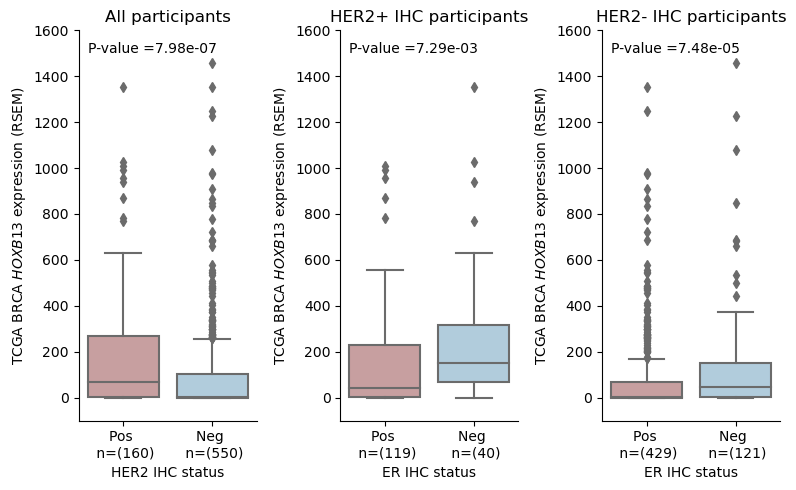

In [20]:
#Manuscript Figure 1A
#ER+/ER- HOXB13 expression box plot, 3rd panel with HER2+ participants ER+ vs ER-

#concatenating the dataframe for figure
#these are temporary dataframes to hold data for the seaborn code to generate the figure
#labelling HERR2 status
TCGA_BRCA_HERnegERpos_mRNA_data.loc["HER2 status"] = 0
TCGA_BRCA_HERposERpos_mRNA_data.loc["HER2 status"] = 1
TCGA_BRCA_HERnegERneg_mRNA_data.loc["HER2 status"] = 0
TCGA_BRCA_HERposERneg_mRNA_data.loc["HER2 status"] = 1

#making temporary dataframes
ERpos_df = pd.concat([TCGA_BRCA_HERposERpos_mRNA_data, TCGA_BRCA_HERnegERpos_mRNA_data], axis=1)
ERpos_df.loc["ER status"] = 1
ERneg_df = pd.concat([TCGA_BRCA_HERposERneg_mRNA_data, TCGA_BRCA_HERnegERneg_mRNA_data], axis=1)
ERneg_df.loc["ER status"] = 0
HER2posdf = pd.concat([ERpos_df, ERneg_df], axis=1)
HER2posdf = HER2posdf.loc[:, HER2posdf.loc["HER2 status"] == 1]
HER2negdf = pd.concat([ERpos_df, ERneg_df], axis=1)
HER2negdf = HER2negdf.loc[:, HER2negdf.loc["HER2 status"] == 0]
concat_HERmRNA_df_HER2pos = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERpos_participants]
concat_HERmRNA_df_HER2pos.loc["HER2 status"] = 1
concat_HERmRNA_df_HER2neg = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERneg_participants]
concat_HERmRNA_df_HER2neg.loc["HER2 status"] = 0

concat_HERmRNA_df = pd.concat([concat_HERmRNA_df_HER2pos, concat_HERmRNA_df_HER2neg], axis = 1)

#code to generate figure
boxplot_palette = ["#CE989A", "#AACEE3"]
fig, ax = plt.subplots(1, 3, figsize=(8, 5))
fig.subplots_adjust(hspace=1, wspace=0.5)
sns.boxplot(palette = boxplot_palette, data = concat_HERmRNA_df, y= concat_HERmRNA_df.loc["HOXB13"], x= concat_HERmRNA_df.loc["HER2 status"], ax = ax[0], order = [1, 0])
ax[0].set_ylabel('TCGA BRCA $\it{HOXB13}$ expression (RSEM)')
ax[0].set_xlabel("HER2 IHC status")
ax[0].text(-0.4, 1500, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(concat_HERmRNA_df_HER2pos.loc['HOXB13'], concat_HERmRNA_df_HER2neg.loc['HOXB13'])[1])));
ax[0].set(ylim=(-100, 1600))
ax[0].set_title(label = "All participants")
ax[0].set_xticklabels(['Pos \n n=(' + str(len(concat_HERmRNA_df_HER2pos.columns)) + ")", 'Neg \n n=(' + str(len(concat_HERmRNA_df_HER2neg.columns)) + ")"])

sns.boxplot(palette = boxplot_palette, x = 'ER status', y = 'HOXB13', data = HER2posdf.transpose().astype(float), ax=ax[1], order=[1, 0])
ax[1].set_ylabel('TCGA BRCA $\it{HOXB13}$ expression (RSEM)')
ax[1].set_xlabel("ER IHC status")
ax[1].text(-0.4, 1500, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_HERposERneg_mRNA_data.loc['HOXB13'], TCGA_BRCA_HERposERpos_mRNA_data.loc['HOXB13'])[1])));
ax[1].set(ylim=(-100, 1600))
ax[1].set_title(label = "HER2+ IHC participants")
ax[1].set_xticklabels(['Pos \n n=(' + str(len(TCGA_BRCA_HERposERpos_mRNA_data.columns)) + ")", 'Neg \n n=(' + str(len(TCGA_BRCA_HERposERneg_mRNA_data.columns)) + ")"])

sns.boxplot(palette = boxplot_palette, x = 'ER status', y = 'HOXB13', data = HER2negdf.transpose().astype(float), ax=ax[2], order=[1, 0])
ax[2].set_ylabel('TCGA BRCA $\it{HOXB13}$ expression (RSEM)')
ax[2].set_xlabel("ER IHC status")
ax[2].text(-0.4, 1500, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_HERnegERneg_mRNA_data.loc['HOXB13'], TCGA_BRCA_HERnegERpos_mRNA_data.loc['HOXB13'])[1])));
ax[2].set(ylim=(-100, 1600))
ax[2].set_title(label = "HER2- IHC participants")
ax[2].set_xticklabels(['Pos \n n=(' + str(len(TCGA_BRCA_HERnegERpos_mRNA_data.columns)) + ")", 'Neg \n n=(' + str(len(TCGA_BRCA_HERnegERneg_mRNA_data.columns)) + ")"])

plt.savefig('Figures/Figure1ABandC.pdf')


INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 45 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'O', 'R', 'S', 'T', 'X', 'a', 'c', 'colon', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'percent', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 8, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 37, 38, 40, 41, 42, 43, 44, 50, 53, 54, 55, 59, 68, 70, 72, 73, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87, 88, 89]
INFO - Closed glyph list over 'GSUB': 50 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'O', 'R', 'S', 'T', 'X', 'a', 'c', 'colon', 'e', 'eight', 'f', 'fi', 'five

ERBB2 Chi squared p value: 1.1069429436484617e-14
HOXB13 Chi squared p value: 0.000291984434297004


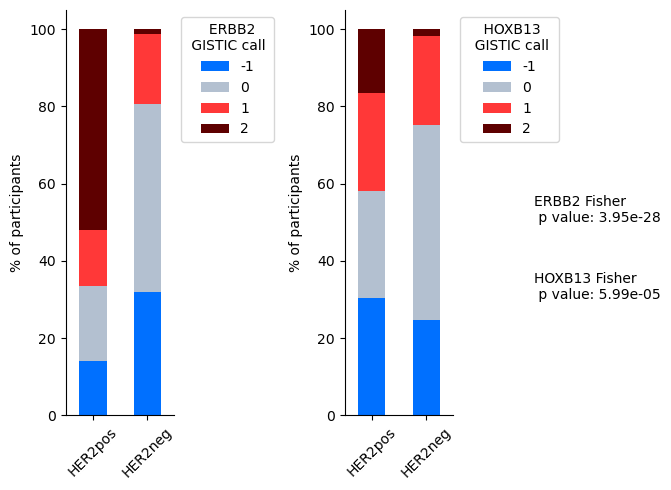

In [21]:
#Figure 2A - CN breakdown with GISTIC calls
gistic_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0070FF","#B3C0D0", "#FF3838", "#5E0000"])
fig, ax = plt.subplots(1, 2, figsize=(7, 5))

figure2AGISTIC_tempdf_ERBB2_HERpos = pd.DataFrame(TCGA_BRCA_tumor_copynumber_data.loc[["ERBB2"], np.in1d(TCGA_BRCA_tumor_copynumber_data.columns, TCGA_BRCA_HERpos_participants)].transpose().value_counts())
figure2AGISTIC_tempdf_ERBB2_HERpos.columns = ["HER2pos"]

#for statistics later
notpercent_figure2AGISTIC_tempdf_ERBB2_HERpos = figure2AGISTIC_tempdf_ERBB2_HERpos.copy()

#making everything fractions
figure2AGISTIC_tempdf_ERBB2_HERpos["HER2pos"] = 100*figure2AGISTIC_tempdf_ERBB2_HERpos["HER2pos"]/sum(figure2AGISTIC_tempdf_ERBB2_HERpos["HER2pos"])

figure2AGISTIC_tempdf_ERBB2_HERneg = pd.DataFrame(TCGA_BRCA_tumor_copynumber_data.loc[["ERBB2"], np.in1d(TCGA_BRCA_tumor_copynumber_data.columns, TCGA_BRCA_HERneg_participants)].transpose().value_counts())
figure2AGISTIC_tempdf_ERBB2_HERneg.columns = ["HER2neg"]

#for statistics later
notpercent_figure2AGISTIC_tempdf_ERBB2_HERneg = figure2AGISTIC_tempdf_ERBB2_HERneg.copy()

#making everything fractions
figure2AGISTIC_tempdf_ERBB2_HERneg["HER2neg"] = 100*figure2AGISTIC_tempdf_ERBB2_HERneg["HER2neg"]/sum(figure2AGISTIC_tempdf_ERBB2_HERneg["HER2neg"])

finalGISTIC_figure2Atempdf_ERBB2 = pd.concat([figure2AGISTIC_tempdf_ERBB2_HERpos, figure2AGISTIC_tempdf_ERBB2_HERneg], axis = 1)
#fixing index and organizing columns
finalGISTIC_figure2Atempdf_ERBB2 = finalGISTIC_figure2Atempdf_ERBB2.reset_index()
finalGISTIC_figure2Atempdf_ERBB2.index = finalGISTIC_figure2Atempdf_ERBB2["ERBB2"]
finalGISTIC_figure2Atempdf_ERBB2.drop(["ERBB2"], axis = 1, inplace = True)
finalGISTIC_figure2Atempdf_ERBB2 = finalGISTIC_figure2Atempdf_ERBB2.transpose()
finalGISTIC_figure2Atempdf_ERBB2 = finalGISTIC_figure2Atempdf_ERBB2[[-1, 0, 1, 2]]

finalGISTIC_figure2Atempdf_ERBB2.plot(kind='bar', stacked=True, ax = ax[0], colormap = gistic_palette)
ax[0].set_ylabel('% of participants')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].legend(bbox_to_anchor=(1.0, 1.0), title="     ERBB2   \n GISTIC call")

figure2AGISTIC_tempdf_HOXB13_HERpos = pd.DataFrame(TCGA_BRCA_tumor_copynumber_data.loc[["HOXB13"], np.in1d(TCGA_BRCA_tumor_copynumber_data.columns, TCGA_BRCA_HERpos_participants)].transpose().value_counts())
figure2AGISTIC_tempdf_HOXB13_HERpos.columns = ["HER2pos"]

#for statistics later
notpercent_figure2AGISTIC_tempdf_HOXB13_HERpos = figure2AGISTIC_tempdf_HOXB13_HERpos.copy()

#making everything fractions
figure2AGISTIC_tempdf_HOXB13_HERpos["HER2pos"] = 100*figure2AGISTIC_tempdf_HOXB13_HERpos["HER2pos"]/sum(figure2AGISTIC_tempdf_HOXB13_HERpos["HER2pos"])

figure2AGISTIC_tempdf_HOXB13_HERneg = pd.DataFrame(TCGA_BRCA_tumor_copynumber_data.loc[["HOXB13"], np.in1d(TCGA_BRCA_tumor_copynumber_data.columns, TCGA_BRCA_HERneg_participants)].transpose().value_counts())
figure2AGISTIC_tempdf_HOXB13_HERneg.columns = ["HER2neg"]

#for statistics later
notpercent_figure2AGISTIC_tempdf_HOXB13_HERneg = figure2AGISTIC_tempdf_HOXB13_HERneg.copy()

#making everything fractions
figure2AGISTIC_tempdf_HOXB13_HERneg["HER2neg"] = 100*figure2AGISTIC_tempdf_HOXB13_HERneg["HER2neg"]/sum(figure2AGISTIC_tempdf_HOXB13_HERneg["HER2neg"])
finalGISTIC_figure2Atempdf_HOXB13 = pd.concat([figure2AGISTIC_tempdf_HOXB13_HERpos, figure2AGISTIC_tempdf_HOXB13_HERneg], axis = 1)
#fixing index and organizing columns
finalGISTIC_figure2Atempdf_HOXB13 = finalGISTIC_figure2Atempdf_HOXB13.reset_index()
finalGISTIC_figure2Atempdf_HOXB13.index = finalGISTIC_figure2Atempdf_HOXB13["HOXB13"]
finalGISTIC_figure2Atempdf_HOXB13.drop(["HOXB13"], axis = 1, inplace = True)
finalGISTIC_figure2Atempdf_HOXB13 = finalGISTIC_figure2Atempdf_HOXB13.transpose()
finalGISTIC_figure2Atempdf_HOXB13 = finalGISTIC_figure2Atempdf_HOXB13[[-1, 0, 1, 2]]

finalGISTIC_figure2Atempdf_HOXB13.plot(kind='bar', stacked=True, ax = ax[1], colormap = gistic_palette)
ax[1].set_ylabel('% of participants')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].legend(bbox_to_anchor=(1.0, 1.0), title="    HOXB13   \n  GISTIC call")

#chi squared p values
stat, p, dof, expected = chi2_contingency(finalGISTIC_figure2Atempdf_ERBB2)
print("ERBB2 Chi squared p value:", str(p))

stat, p, dof, expected = chi2_contingency(finalGISTIC_figure2Atempdf_HOXB13)
print("HOXB13 Chi squared p value:", str(p))

#fisher tables
fig2A_ERBB2fisherdf = pd.DataFrame()
fig2A_ERBB2fisherdf.loc["not gained", "HER2+"] = 31+22
fig2A_ERBB2fisherdf.loc["gained", "HER2+"] = 23+82
fig2A_ERBB2fisherdf.loc["not gained", "HER2-"] = 266+175
fig2A_ERBB2fisherdf.loc["gained", "HER2-"] = 98+7
plt.text(3, 50, "ERBB2 Fisher \n p value: " + str("{:.3}".format(fisher_exact(fig2A_ERBB2fisherdf, alternative='two-sided')[1])))

fig2A_HOXB13fisherdf = pd.DataFrame()
fig2A_HOXB13fisherdf.loc["not gained", "HER2+"] = 44+48
fig2A_HOXB13fisherdf.loc["gained", "HER2+"] = 40+26
fig2A_HOXB13fisherdf.loc["not gained", "HER2-"] = 275+135
fig2A_HOXB13fisherdf.loc["gained", "HER2-"] = 126+10
plt.text(3, 30, "HOXB13 Fisher \n p value: " + str("{:.3}".format(fisher_exact(fig2A_HOXB13fisherdf, alternative='two-sided')[1])))

plt.savefig('Figures/Figure2AB.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 41 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'G', 'H', 'O', 'R', 'T', 'X', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38, 40, 42, 43, 50, 53, 55, 59, 68, 69, 70, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO - Closed glyph list over 'GSUB': 41 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'G', 'H', 'O', 'R', 'T', 'X', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o'

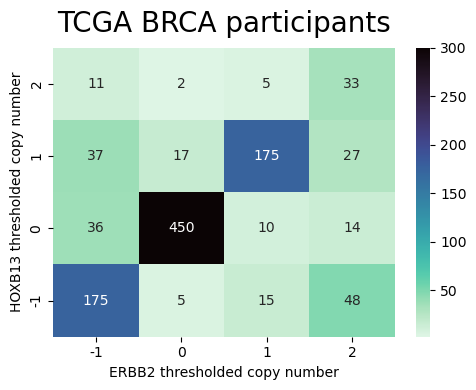

In [22]:
#Figure 2C
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
temp_df_erb0 = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 0].columns
temp_df_erbneg1 = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == -1].columns
temp_df_erb1 = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 1].columns
temp_df_erb2 = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 2].columns

temp_fulldfheatmap = pd.DataFrame(data = TCGA_BRCA_tumor_copynumber_data.loc['HOXB13', temp_df_erb0].value_counts())
temp_fulldfheatmap.columns = ["ERBB2=0"]
temp_fulldfheatmap["ERBB2=1"] = TCGA_BRCA_tumor_copynumber_data.loc['HOXB13', temp_df_erb1].value_counts()
temp_fulldfheatmap["ERBB2=-1"] = TCGA_BRCA_tumor_copynumber_data.loc['HOXB13', temp_df_erbneg1].value_counts()
temp_fulldfheatmap["ERBB2=2"] = TCGA_BRCA_tumor_copynumber_data.loc['HOXB13', temp_df_erb2].value_counts()
temp_fulldfheatmap.index = ["HOXB13=0", "HOXB13=1", "HOXB13=-1", "HOXB13=2"]
temp_fulldfheatmap = temp_fulldfheatmap.loc[["HOXB13=2", "HOXB13=1", "HOXB13=0", "HOXB13=-1"]]
temp_fulldfheatmap = temp_fulldfheatmap[["ERBB2=-1", "ERBB2=0", "ERBB2=1", "ERBB2=2"]]

#changing the labels for the heatmap plot
TCGA_fulldfheatmap_zerolabels = temp_fulldfheatmap.copy()
TCGA_fulldfheatmap_zerolabels.index = [2, 1, 0, -1]
TCGA_fulldfheatmap_zerolabels.columns = [-1, 0, 1, 2]
sns.heatmap(data = TCGA_fulldfheatmap_zerolabels, annot = True, cmap='mako_r', fmt=".0f", ax = ax, vmax = 300)
ax.set_title("TCGA BRCA participants", y = 1.025, size = 20)
ax.set_ylabel('HOXB13 thresholded copy number')
ax.set_xlabel('ERBB2 thresholded copy number')

plt.savefig('Figures/Figure2C.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 27 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'E', 'H', 'O', 'R', 'X', 'a', 'd', 'e', 'eight', 'five', 'four', 'g', 'i', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'three', 'two', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 37, 40, 43, 50, 53, 59, 68, 71, 72, 74, 76, 81, 82, 87]
INFO - Closed glyph list over 'GSUB': 27 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'E', 'H', 'O', 'R', 'X', 'a', 'd', 'e', 'eight', 'five', 'four', 'g', 'i', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'three', 'two', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 37, 40, 43, 50, 53, 59, 68, 71, 72, 74, 76, 81, 8

(23.8602776533811, 2.0501908348901774e-94)

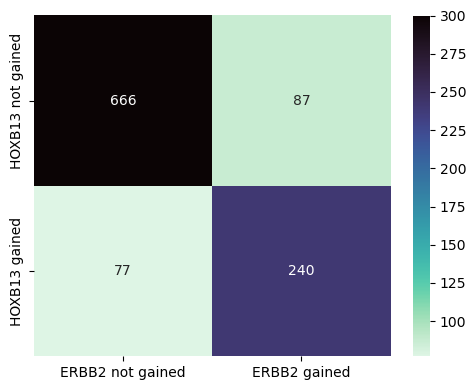

In [23]:
#for the manuscript
statistics_df1 = pd.DataFrame()
statistics_df1.loc["HOXB13 not gained", "ERBB2 not gained"] = 36+450+175+5
statistics_df1.loc["HOXB13 gained", "ERBB2 not gained"] = 37+17+11+12
statistics_df1.loc["HOXB13 not gained", "ERBB2 gained"] = 15+10+14+48
statistics_df1.loc["HOXB13 gained", "ERBB2 gained"] = 175+27+5+33


fig, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.heatmap(data = statistics_df1, annot = True, cmap='mako_r', fmt=".0f", ax = ax, vmax = 300)
plt.savefig('Figures/Figure2C_part2.pdf')
fisher_exact(statistics_df1, alternative='two-sided')


INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 42 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'J', 'L', 'N', 'O', 'R', 'S', 'T', 'U', 'a', 'b', 'd', 'e', 'eight', 'five', 'four', 'g', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 40, 45, 47, 49, 50, 53, 54, 55, 56, 68, 69, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO - Closed glyph list over 'GSUB': 42 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'J', 'L', 'N', 'O', 'R', 'S', 'T', 'U', 'a', 'b', 'd', 'e', 'eight', 'five', 'four', 'g', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingre

Number of jointly gained patients:  240


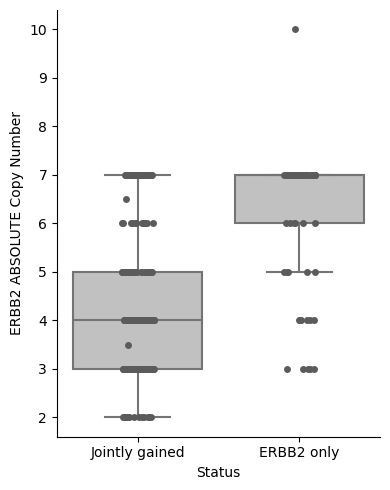

In [24]:
#Figure 2D
#erbb2 absolute copy number for jount gained vs errby only gained
TCGA_BRCA_co_gained_participants = list(TCGA_BRCA_co_gained_participants)
TCGA_BRCA_ERBB2only_participants = list(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_gap_participants = list(TCGA_BRCA_gap_participants)

gistic_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0070FF","#B3C0D0", "#FF3838", "#5E0000"])
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

TCGA_BRCA_jointlygained_participants = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns)
print("Number of jointly gained patients: ", len(TCGA_BRCA_jointlygained_participants))

figure2AGISTIC_tempdf_ERBB2_jointgain = pd.DataFrame(TCGA_BRCA_callsonlyERBB2.loc[np.in1d(TCGA_BRCA_callsonlyERBB2.index, TCGA_BRCA_jointlygained_participants), ["Copy number"]])
figure2AGISTIC_tempdf_ERBB2_jointgain["Status"] = "Jointly gained"

figure2AGISTIC_tempdf_ERBB2_erbb2only = pd.DataFrame(TCGA_BRCA_callsonlyERBB2.loc[np.in1d(TCGA_BRCA_callsonlyERBB2.index, TCGA_BRCA_ERBB2only_participants), ["Copy number"]])
figure2AGISTIC_tempdf_ERBB2_erbb2only["Status"] = "ERBB2 only"

finalGISTIC_figure2Atempdf_ERBB2 = pd.concat([figure2AGISTIC_tempdf_ERBB2_jointgain, figure2AGISTIC_tempdf_ERBB2_erbb2only], axis = 0)

sns.boxplot(x = finalGISTIC_figure2Atempdf_ERBB2["Status"], y = finalGISTIC_figure2Atempdf_ERBB2["Copy number"], color = "#c1c1c1", showfliers=False)
sns.stripplot(x = finalGISTIC_figure2Atempdf_ERBB2["Status"], y = finalGISTIC_figure2Atempdf_ERBB2["Copy number"], color = "#5b5b5b")

ax.set_ylabel('ERBB2 ABSOLUTE Copy Number')
ax.tick_params(axis='x', labelrotation = 0)


plt.savefig('Figures/Figure2D.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 53 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'G', 'H', 'M', 'O', 'P', 'R', 'T', 'U', 'X', 'a', 'b', 'c', 'd', 'e', 'eight', 'equal', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 11, 12, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 36, 37, 38, 40, 42, 43, 48, 50, 51, 53, 55, 56, 59, 68, 69, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 92]
INFO - Closed glyph list over 'GSUB': 53 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E'

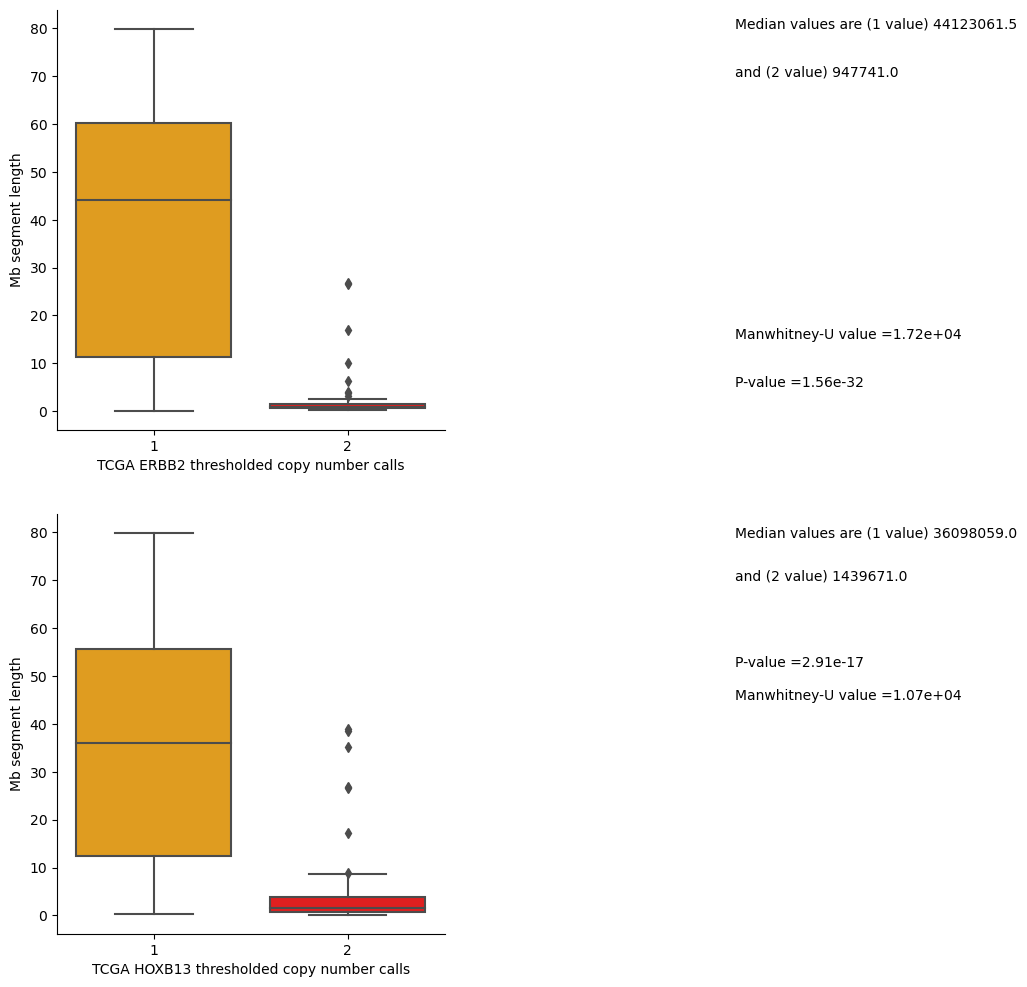

In [25]:
#Figure 3A - figure plotting the length distributions (box or violin) with GISTIC calls
#of the segments overlapping HER2 (from the seg file – pull out the length of any segment that touches HER2), 
#for gains (1-2 extra copies) and then for amplifications (3+ extra copies)
#using mb since segments are very large
fig, ax = plt.subplots(2, 1, figsize=(5, 12))
TCGA_BRCA_callsonlyERBB2.loc[:, "Mb segment length"] = (TCGA_BRCA_callsonlyERBB2.loc[:, "Segment_length"])/1000000


#adding back in thresholded data to calculate the p value
TCGA_BRCA_callsonlyERBB2["Thresholded calls"] = TCGA_BRCA_tumor_copynumber_data.loc["ERBB2"]
figure3ATCGA_CN1_tempdf = TCGA_BRCA_callsonlyERBB2.loc[TCGA_BRCA_callsonlyERBB2["Thresholded calls"] == 1]
figure3ATCGA_CN2_tempdf = TCGA_BRCA_callsonlyERBB2.loc[TCGA_BRCA_callsonlyERBB2["Thresholded calls"] == 2]
figure3ATCGA_CN1and2_tempdf = pd.concat([figure3ATCGA_CN2_tempdf, figure3ATCGA_CN1_tempdf], axis = 0)

sns.boxplot(y = figure3ATCGA_CN1and2_tempdf.loc[:, "Mb segment length"], ax = ax[0], x = figure3ATCGA_CN1and2_tempdf.loc[:, "Thresholded calls"], palette = sns.color_palette(["orange", "red"]))
ax[0].set_ylabel("Mb segment length")
ax[0].text(3, 5.0, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(figure3ATCGA_CN1_tempdf.loc[:, "Segment_length"], figure3ATCGA_CN2_tempdf.loc[:, "Segment_length"])[1])));
ax[0].text(3, 15.1, '\nManwhitney-U value ='  + str("{:.2e}".format(mannwhitneyu(figure3ATCGA_CN1_tempdf["Segment_length"], figure3ATCGA_CN2_tempdf["Segment_length"])[0])));
ax[0].text(3, 80, 'Median values are (1 value) ' + str(np.median(figure3ATCGA_CN1_tempdf.loc[:, "Segment_length"])))
ax[0].text(3, 70, 'and (2 value) ' + str(np.median(figure3ATCGA_CN2_tempdf.loc[:, "Segment_length"])))
ax[0].set_xlabel('TCGA ERBB2 thresholded copy number calls')

TCGA_BRCA_callsonlyHOXB13.loc[:, "Mb segment length"] = (TCGA_BRCA_callsonlyHOXB13.loc[:, "Segment_length"])/1000000


#adding back in thresholded data to calculate the p value
TCGA_BRCA_callsonlyHOXB13["Thresholded calls"] = TCGA_BRCA_tumor_copynumber_data.loc["HOXB13"]
figure3ATCGA_CN1_tempdf = TCGA_BRCA_callsonlyHOXB13.loc[TCGA_BRCA_callsonlyHOXB13["Thresholded calls"] == 1]
figure3ATCGA_CN2_tempdf = TCGA_BRCA_callsonlyHOXB13.loc[TCGA_BRCA_callsonlyHOXB13["Thresholded calls"] == 2]
figure3ATCGA_CN1and2_tempdf = pd.concat([figure3ATCGA_CN2_tempdf, figure3ATCGA_CN1_tempdf], axis = 0)

sns.boxplot(y = figure3ATCGA_CN1and2_tempdf.loc[:, "Mb segment length"], ax = ax[1], x = figure3ATCGA_CN1and2_tempdf.loc[:, "Thresholded calls"], palette = sns.color_palette(["orange", "red"]))
ax[1].set_ylabel("Mb segment length")
ax[1].text(3, 52, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(figure3ATCGA_CN1_tempdf.loc[:, "Segment_length"], figure3ATCGA_CN2_tempdf.loc[:, "Segment_length"])[1])));
ax[1].text(3, 45, '\nManwhitney-U value ='  + str("{:.2e}".format(mannwhitneyu(figure3ATCGA_CN1_tempdf["Segment_length"], figure3ATCGA_CN2_tempdf["Segment_length"])[0])));
ax[1].text(3, 79, 'Median values are (1 value) ' + str(np.median(figure3ATCGA_CN1_tempdf.loc[:, "Segment_length"])))
ax[1].text(3, 70, 'and (2 value) ' + str(np.median(figure3ATCGA_CN2_tempdf.loc[:, "Segment_length"])))
ax[1].set_xlabel('TCGA HOXB13 thresholded copy number calls')


plt.savefig('Figures/Figure3A.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 10 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'R', 'S', 'T', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 36, 37, 38, 53, 54, 55]
INFO - Closed glyph list over 'GSUB': 10 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'R', 'S', 'T', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 36, 37, 38, 53, 54, 55]
INFO - Closing glyph list over 'glyf': 10 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'R', 'S', 'T', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 36, 37, 38, 53, 54, 55]
INFO - Closed glyph list over 'glyf': 10 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'R', 'S', 'T', 'nonmarkingretu

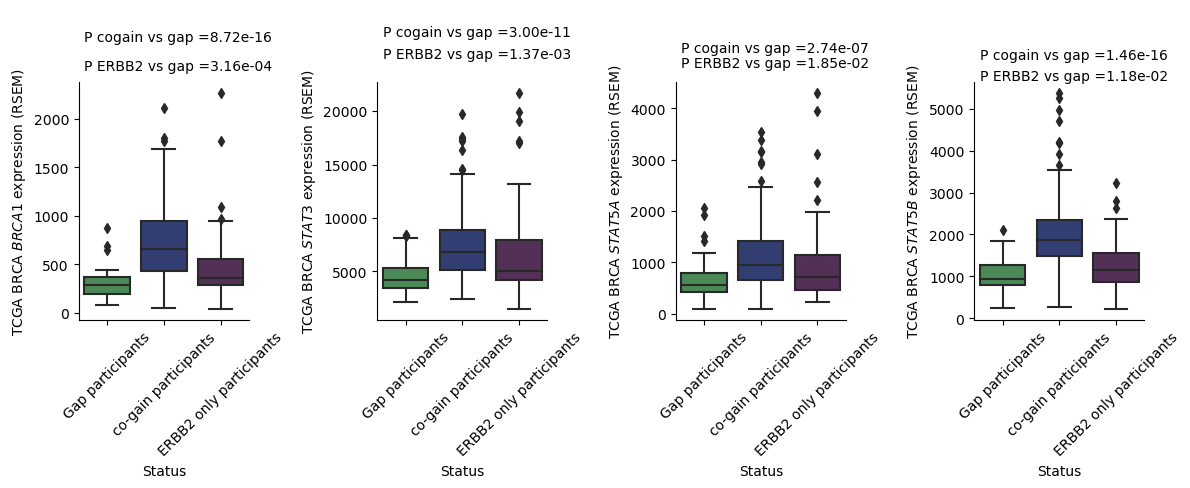

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(12, 5))
gene_palette = ["#419450", "#28387C", "#592A5C"]

Figure_6H_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
Figure_6H_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2 only participants"
Figure_6H_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap participants"
Figure_6H_tempdf.loc["Status", TCGA_BRCA_co_gained_participants] = "co-gain participants"

sns.boxplot(y = Figure_6H_tempdf.loc["BRCA1"], x = Figure_6H_tempdf.loc["Status"], ax = ax[0], palette = gene_palette)
ax[0].set_ylabel('TCGA BRCA $\it{BRCA1}$ expression (RSEM)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].text(-0.4, 2800, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[0].text(-0.4, 2500, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_ERBB2only_participants].dropna())[1])));

sns.boxplot(y = Figure_6H_tempdf.loc["STAT3"], x = Figure_6H_tempdf.loc["Status"], ax = ax[1], palette = gene_palette)
ax[1].set_ylabel('TCGA BRCA $\it{STAT3}$ expression (RSEM)')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].text(-0.4, 27000, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[1].text(-0.4, 25000, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_ERBB2only_participants].dropna())[1])));

sns.boxplot(y = Figure_6H_tempdf.loc["STAT5A"], x = Figure_6H_tempdf.loc["Status"], ax = ax[2], palette = gene_palette)
ax[2].set_ylabel('TCGA BRCA $\it{STAT5A}$ expression (RSEM)')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)
ax[2].text(-0.4, 5100, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[2].text(-0.4, 4800, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_ERBB2only_participants].dropna())[1])));

sns.boxplot(y = Figure_6H_tempdf.loc["STAT5B"], x = Figure_6H_tempdf.loc["Status"], ax = ax[3], palette = gene_palette)
ax[3].set_ylabel('TCGA BRCA $\it{STAT5B}$ expression (RSEM)')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)
ax[3].text(-0.4, 6200, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[3].text(-0.4, 5700, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_ERBB2only_participants].dropna())[1])));

plt.savefig('Figures/Figure3H.pdf')

WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 54 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'O', 'R', 'S', 'T', 'U', 'X', 'Z', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 53, 54, 55, 56, 59, 61, 68, 69, 70, 71, 72, 74, 75, 76, 79

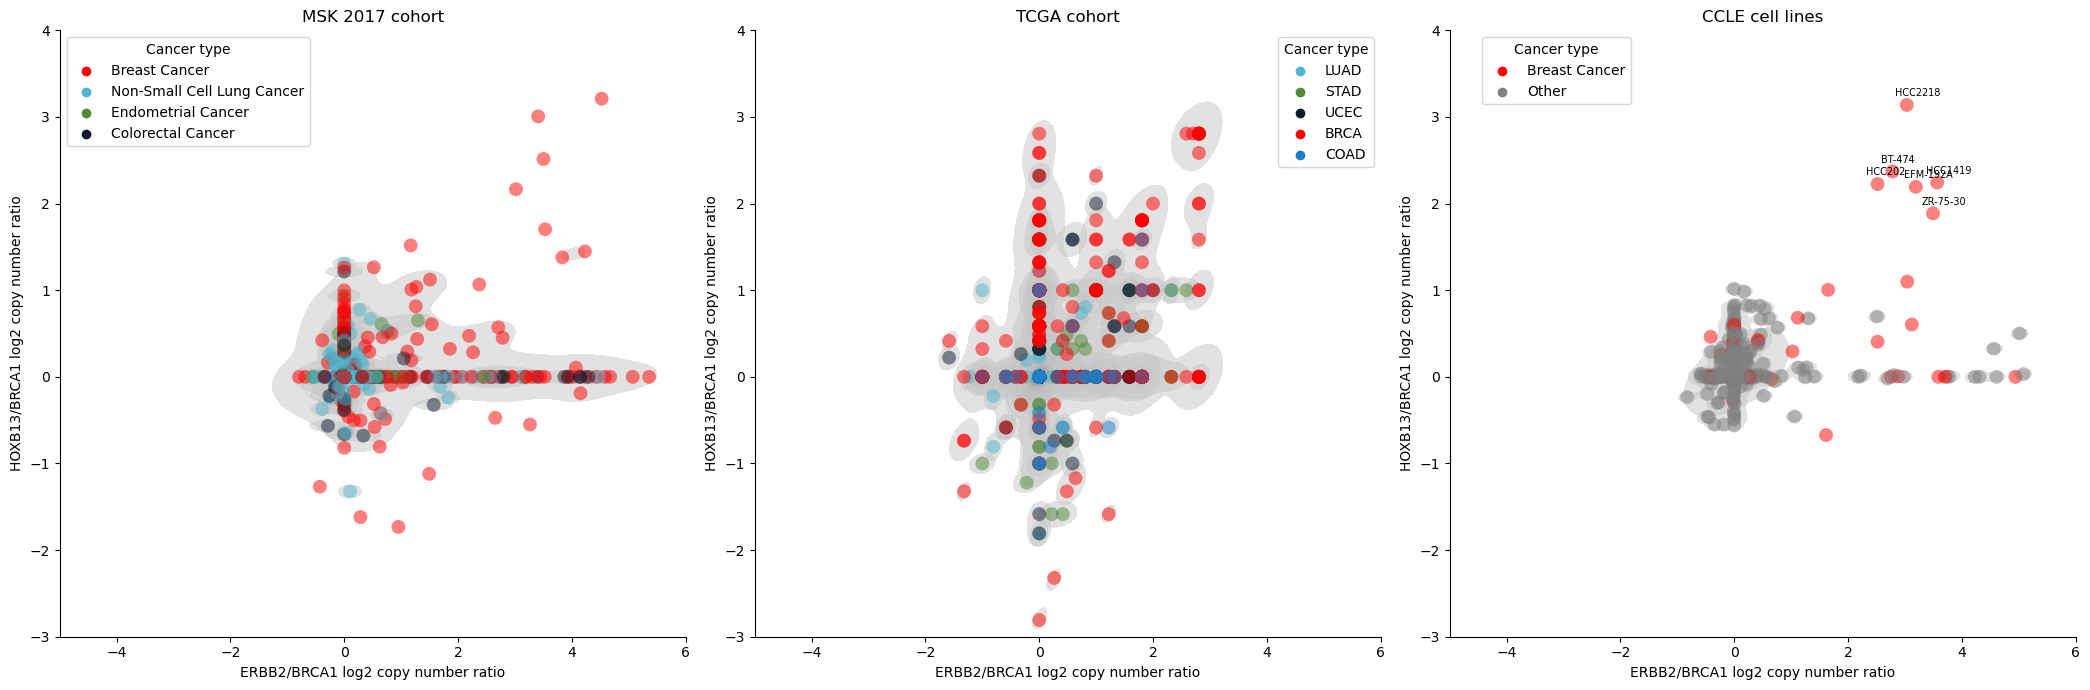

In [27]:
#Figure 4ABC
MSK_palette = sns.color_palette(["red", "#50b5cd", "#508938", "#0f1a2e", "#1e7fc7", "#0000ff"])

fig, ax = plt.subplots(1, 3, figsize=(21, 7))
sns.kdeplot(x = MSK_figure_df["ERBB2/BRCA1"].astype(float), y=MSK_figure_df["HOXB13/BRCA1"].astype(float), hue=MSK_figure_df["Cancer type"], alpha = 0.5, palette = ["#757575"], s=100, ax = ax[0], fill = True, thresh = 0.01)


sns.kdeplot(x = allgenes_concat_organ_CNdf["log2 ERBB2/BRCA1"].astype(float), y=allgenes_concat_organ_CNdf["log2 HOXB13/BRCA1"].astype(float), ax = ax[1], hue=allgenes_concat_organ_CNdf["Cancer type"], alpha = 0.5, palette = ["#757575"], s=100, fill = True, thresh = 0.01)


palette = ["Red", "Grey"]
sns.kdeplot(data = CCLE_allcelllines_CN_data, y = CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"], x = CCLE_allcelllines_CN_data["ERBB2/BRCA1 copy number ratio"], hue = CCLE_allcelllines_CN_data["Color"], palette = ["#757575"], alpha = 0.5, s=100, ax = ax[2], fill = True, thresh = 0.01)
ax[2].legend(bbox_to_anchor=(0.3, 1.0), title = "Cancer type")

ax[2].yaxis.set_major_locator(MultipleLocator(1))

sns.scatterplot(x = MSK_figure_df["ERBB2/BRCA1"].astype(float), y=MSK_figure_df["HOXB13/BRCA1"].astype(float), hue=MSK_figure_df["Cancer type"], alpha = 0.5, palette = MSK_palette, s=100, ax = ax[0], linewidth=0)


sns.scatterplot(x = allgenes_concat_organ_CNdf["log2 ERBB2/BRCA1"].astype(float), y=allgenes_concat_organ_CNdf["log2 HOXB13/BRCA1"].astype(float), ax = ax[1], hue=allgenes_concat_organ_CNdf["Cancer type"], alpha = 0.5, palette = palette_1, s=100, linewidth=0)

sns.scatterplot(data = CCLE_allcelllines_CN_data, y = CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"], x = CCLE_allcelllines_CN_data["ERBB2/BRCA1 copy number ratio"], hue = CCLE_allcelllines_CN_data["Color"], palette = palette, linewidth=0, alpha = 0.5, s=100, ax = ax[2])
ax[2].legend(bbox_to_anchor=(0.3, 1.0), title = "Cancer type")

for index, row in CCLE_allcelllines_CN_data[CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"]>1.5].iterrows():
    ax[2].text(row["ERBB2/BRCA1 copy number ratio"]-0.2, row["HOXB13/BRCA1 copy number ratio"]+0.1, row["Cell_line_name"], size =7)


ax[0].set_ylabel("HOXB13/BRCA1 log2 copy number ratio")
ax[0].set_xlabel("ERBB2/BRCA1 log2 copy number ratio")
ax[1].set_ylabel("HOXB13/BRCA1 log2 copy number ratio")
ax[1].set_xlabel("ERBB2/BRCA1 log2 copy number ratio")
ax[2].set_ylabel("HOXB13/BRCA1 log2 copy number ratio")
ax[2].set_xlabel("ERBB2/BRCA1 log2 copy number ratio")

ax[0].set_xlim(-5, 6)
ax[1].set_xlim(-5, 6)
ax[2].set_xlim(-5, 6)
ax[0].set_ylim(-3, 4)
ax[1].set_ylim(-3, 4)
ax[2].set_ylim(-3, 4)

ax[0].set_title("MSK 2017 cohort")
ax[1].set_title("TCGA cohort")
ax[2].set_title("CCLE cell lines")

plt.savefig('Figures/Figure4ABC.pdf')


INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 30 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'five', 'four', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60]
INFO - Closed glyph list over 'GSUB': 30 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'five', 'four', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47,

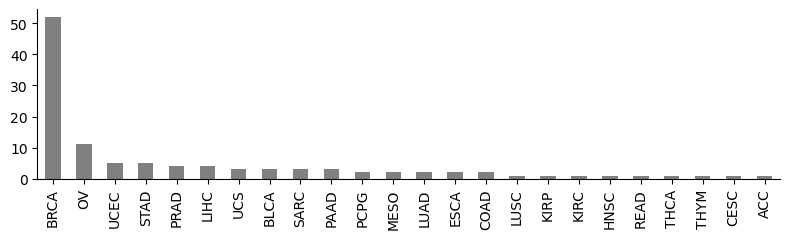

In [28]:
#Figure 4D
#HOXB13 amp unique to BRCA

fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
pancan_HOX_amped_participants = pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['HOXB13'] > 1].columns
pancancer_clinical_and_survival_data.loc[np.in1d(pancancer_clinical_and_survival_data.index, pancan_HOX_amped_participants), "type"].value_counts().plot(kind='bar', color = "grey")

plt.savefig("Figures/Figure4D.pdf")

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 39 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'G', 'N', 'P', 'R', 'S', 'a', 'b', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'v', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 24, 26, 27, 28, 32, 37, 38, 40, 42, 49, 51, 53, 54, 68, 69, 72, 73, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
INFO - Closed glyph list over 'GSUB': 44 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'G', 'N', 'P', 'R', 'S', 'a', 'b', 'e', 'eight', 'equal', 'f', 'fi', 'five', 'fl', 'four', 'g', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p',

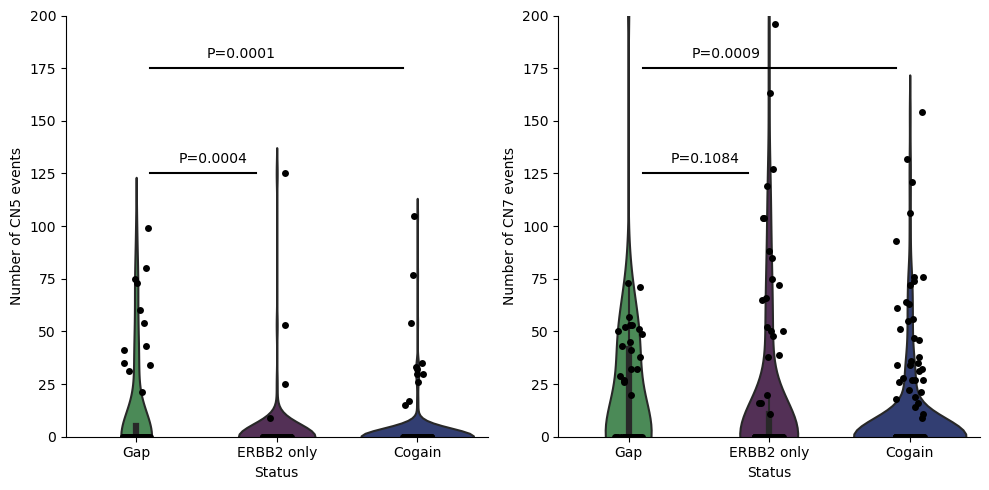

In [29]:
#Figure 5D
#Using assignment for CNV
CNV_mastercalls = mastercalls.dropna(axis = 0, thresh = 17)
CNV_participants = set(CNV_mastercalls.index) & (set(TCGA_BRCA_gap_participants) | set(TCGA_BRCA_ERBB2only_participants) | set(TCGA_BRCA_co_gained_participants))

for name in CNV_participants:
    if (not Path("individual_CNV/{}_CNVassignmentoutput/Assignment_Solution/Activities/Assignment_Solution_Activities.txt".format(name)).is_file()):
        current_calls = pd.DataFrame()
        current_calls = mastercalls.loc[name]
        current_calls.index = range(0, len(current_calls.index))
        current_calls.columns = ['sample', 'Chromosome', 'Start', 'End', 'Num_Probes', 'Length',
       'Modal_HSCN_1', 'Modal_HSCN_2', 'Modal_Total_CN', 'Subclonal_HSCN_a1',
       'Subclonal_HSCN_a2', 'Cancer_cell_frac_a1', 'Ccf_ci95_low_a1',
       'Ccf_ci95_high_a1', 'Cancer_cell_frac_a2', 'Ccf_ci95_low_a2',
       'Ccf_ci95_high_a2', 'LOH', 'Homozygous_deletion', 'solution']
        current_calls.to_csv("individual_CNV/{}_calls.txt".format(name), index = False, header = True, sep='\t')
    
        scna.generateCNVMatrix("ABSOLUTE", "individual_CNV/{}_calls.txt".format(name), "individual_CNV/{}_CNVmatrix".format(name), "./")
        Analyze.cosmic_fit("individual_CNV/{}_CNVmatrix.CNV48.matrix.tsv".format(name), "individual_CNV/{}_CNVassignmentoutput".format(name), "vcf",sample_reconstruction_plots = "pdf", collapse_to_SBS96 = False)
        

pt_names = listdir("individual_CNV", "*_CNVassignmentoutput")
COSMIC_assigned_dict = {}

for x in range(0, len(pt_names)):
    #CNV
    CNV48_data = pd.read_csv("individual_CNV/{}/Assignment_Solution/Activities/Assignment_Solution_Activities.txt".format(pt_names[x]), sep = "\t").apply(pd.to_numeric, errors = "ignore")
    CNV48_data = CNV48_data.drop(["Samples"], axis = 1)
    COSMIC_assigned_dict[pt_names[x]]= CNV48_data
    
COSMIC_assigned_final_df = pd.concat(COSMIC_assigned_dict.values(),keys=COSMIC_assigned_dict.keys()).apply(pd.to_numeric, errors = "coerce")
COSMIC_assigned_final_df.index = pt_names
COSMIC_assigned_final_df.index = [x.split("_CNV")[0] for x in COSMIC_assigned_final_df.index]


concat_pt_list = list(TCGA_BRCA_gap_participants) + list(TCGA_BRCA_ERBB2only_participants) + list(TCGA_BRCA_co_gained_participants)
sorted_concat_pt_list = [ele for ele in concat_pt_list if ele in COSMIC_assigned_final_df.index]
COSMIC_assigned_final_df = COSMIC_assigned_final_df.loc[sorted_concat_pt_list]

for x in range(1, 25):
    column_sum = COSMIC_assigned_final_df.sum(axis = 1)
    COSMIC_assigned_final_df["% CN{}".format(x)] = 100*COSMIC_assigned_final_df["CN{}".format(x)]/column_sum

COSMIC_assigned_final_df["Status"] = "N/A"
COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_gap_participants), "Status"] = "Gap"
COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_ERBB2only_participants), "Status"] = "ERBB2 only"
COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_co_gained_participants), "Status"] = "Cogain"
COSMIC_assigned_final_df.to_csv("Figures/TCGA_CNVprojections.csv")

#making pairwise p val dataframe
cosmicassigned_pval_pairwise_df = pd.DataFrame(columns = ["P value"])
for x in range(1, 25):
    cosmicassigned_pval_pairwise_df.loc["ERBB2 vs gap CN{}".format(x), "P value"] = mannwhitneyu(COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_ERBB2only_participants), "% CN{}".format(x)], COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_gap_participants), "% CN{}".format(x)])[1]
    cosmicassigned_pval_pairwise_df.loc["cogain vs gap CN{}".format(x), "P value"] = mannwhitneyu(COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_co_gained_participants), "% CN{}".format(x)], COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_gap_participants), "% CN{}".format(x)])[1]

#CN7 and 5 for the manuscript
cosmic_palette = ["#419450", "#592A5C", "#28387C"]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.violinplot(data = COSMIC_assigned_final_df, y = COSMIC_assigned_final_df["CN5"], x = COSMIC_assigned_final_df["Status"], ax = ax[0], palette = cosmic_palette).set_ylabel("Number of CN5 events")
sns.violinplot(data = COSMIC_assigned_final_df, y = COSMIC_assigned_final_df["CN7"], x = COSMIC_assigned_final_df["Status"], ax = ax[1], palette = cosmic_palette).set_ylabel("Number of CN7 events")
sns.stripplot(data = COSMIC_assigned_final_df, y = COSMIC_assigned_final_df["CN5"], x = COSMIC_assigned_final_df["Status"], ax = ax[0], color = "black").set_ylabel("Number of CN5 events")
sns.stripplot(data = COSMIC_assigned_final_df, y = COSMIC_assigned_final_df["CN7"], x = COSMIC_assigned_final_df["Status"], ax = ax[1], color = "black").set_ylabel("Number of CN7 events")


ax[0].set_ylim(0, 200)
ax[1].set_ylim(0, 200)
ax[0].axhline(y=175, xmin=0.2, xmax=0.8, color="black")
ax[0].axhline(y=125, xmin=0.2, xmax=0.45, color="black")
ax[1].axhline(y=175, xmin=0.2, xmax=0.8, color="black")
ax[1].axhline(y=125, xmin=0.2, xmax=0.45, color="black")

ax[0].text(0.3, 130, "P=" + str("{0:.4f}".format(cosmicassigned_pval_pairwise_df.loc["ERBB2 vs gap CN5", "P value"])))
ax[1].text(0.3, 130, "P=" + str("{0:.4f}".format(cosmicassigned_pval_pairwise_df.loc["ERBB2 vs gap CN7", "P value"])))
ax[0].text(0.5, 180, "P=" + str("{0:.4f}".format(cosmicassigned_pval_pairwise_df.loc["cogain vs gap CN5", "P value"])))
ax[1].text(0.45, 180, "P=" + str("{0:.4f}".format(cosmicassigned_pval_pairwise_df.loc["cogain vs gap CN7", "P value"])))


plt.savefig('Figures/Figure5D.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 54 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'R', 'S', 'T', 'V', 'W', 'a', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'percent', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'v', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 8, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 29, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 53, 54, 55, 57, 58, 68, 70, 71, 72, 73, 74, 75, 76, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92]
INFO - Closed glyph list over 'GSUB': 59 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', '

Chisquared p value 0.0007645311078674454


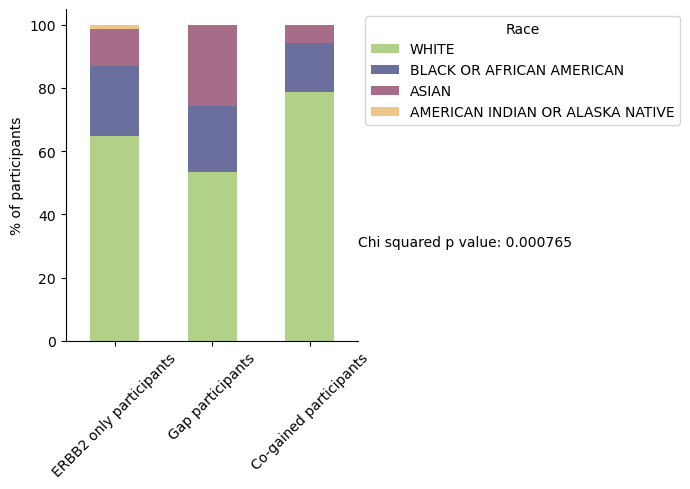

In [30]:
#Figure 5E
#checking distribution of race across the 3 groups
tcgarace_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#B2D188", "#6A6F9D", "#A76C88", "#EDC58B"])

combined_racedf = pd.DataFrame()
combined_racedf["ERBB2 only participants"] = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_ERBB2only_participants, "race"].value_counts()
combined_racedf["Gap participants"] = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_gap_participants, "race"].value_counts()
combined_racedf["Co-gained participants"] = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_co_gained_participants, "race"].value_counts()
combined_racedf = combined_racedf.fillna(0)
combined_racedf = combined_racedf.transpose()
#dropping those without any data entered
combined_racedf = combined_racedf.drop("[Not Available]", axis = 1)

#getting % values
for x in range (0, len(combined_racedf.index)):
    combined_racedf.iloc[x] = (combined_racedf.iloc[x] * 100)/combined_racedf.iloc[x].sum()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
combined_racedf.plot(kind='bar', stacked=True, ax = ax, colormap = tcgarace_palette)
plt.xticks(rotation = 45)
ax.set_ylabel('% of participants')
ax.legend(bbox_to_anchor=(1.0, 1.0), title="Race")
#p values
stat, p, dof, expected = chi2_contingency(combined_racedf)
print("Chisquared p value", str(p))
plt.text(2.5, 30, "Chi squared p value: " + str("{:.3}".format(p)))

plt.savefig('Figures/Figure5E.pdf')

Median survival for Gap 2893.537503171
Median survival for ERBB2 only gained 6058.3916733060005
Pairwise p value for Gap vs ERBB2 only gained : 0.068
Median survival for Gap 3014.0
Median survival for ERBB2 only gained 4456.0
Pairwise p value for Gap vs ERBB2 only gained : 0.77
Median survival for Gap 998.579167761
Median survival for ERBB2 only gained 6058.3916733060005
Pairwise p value for Gap vs ERBB2 only gained : 0.0078
Median survival for Gap 2893.537503171
Median survival for co-gained 5440.933339296
Pairwise p value for Gap vs co-gained : 0.022
Median survival for Gap 3014.0
Median survival for co-gained 5440.933339296
Pairwise p value for Gap vs co-gained : 0.47
Median survival for Gap 998.579167761
Median survival for co-gained 2041.0
Pairwise p value for Gap vs co-gained : 0.26
Median survival for co-gained 5440.933339296
Median survival for ERBB2 only gained 6058.3916733060005
Pairwise p value for co-gained vs ERBB2 only gained : 0.66
Median survival for co-gained 5440.9333

['Gap vs ERBB2 only gained: 0.068',
 'Gap vs ERBB2 only gained: 0.77',
 'Gap vs ERBB2 only gained: 0.0078',
 'Gap vs co-gained: 0.022',
 'Gap vs co-gained: 0.47',
 'Gap vs co-gained: 0.26',
 'co-gained vs ERBB2 only gained: 0.66',
 'co-gained vs ERBB2 only gained: 0.49',
 'co-gained vs ERBB2 only gained: 0.26']

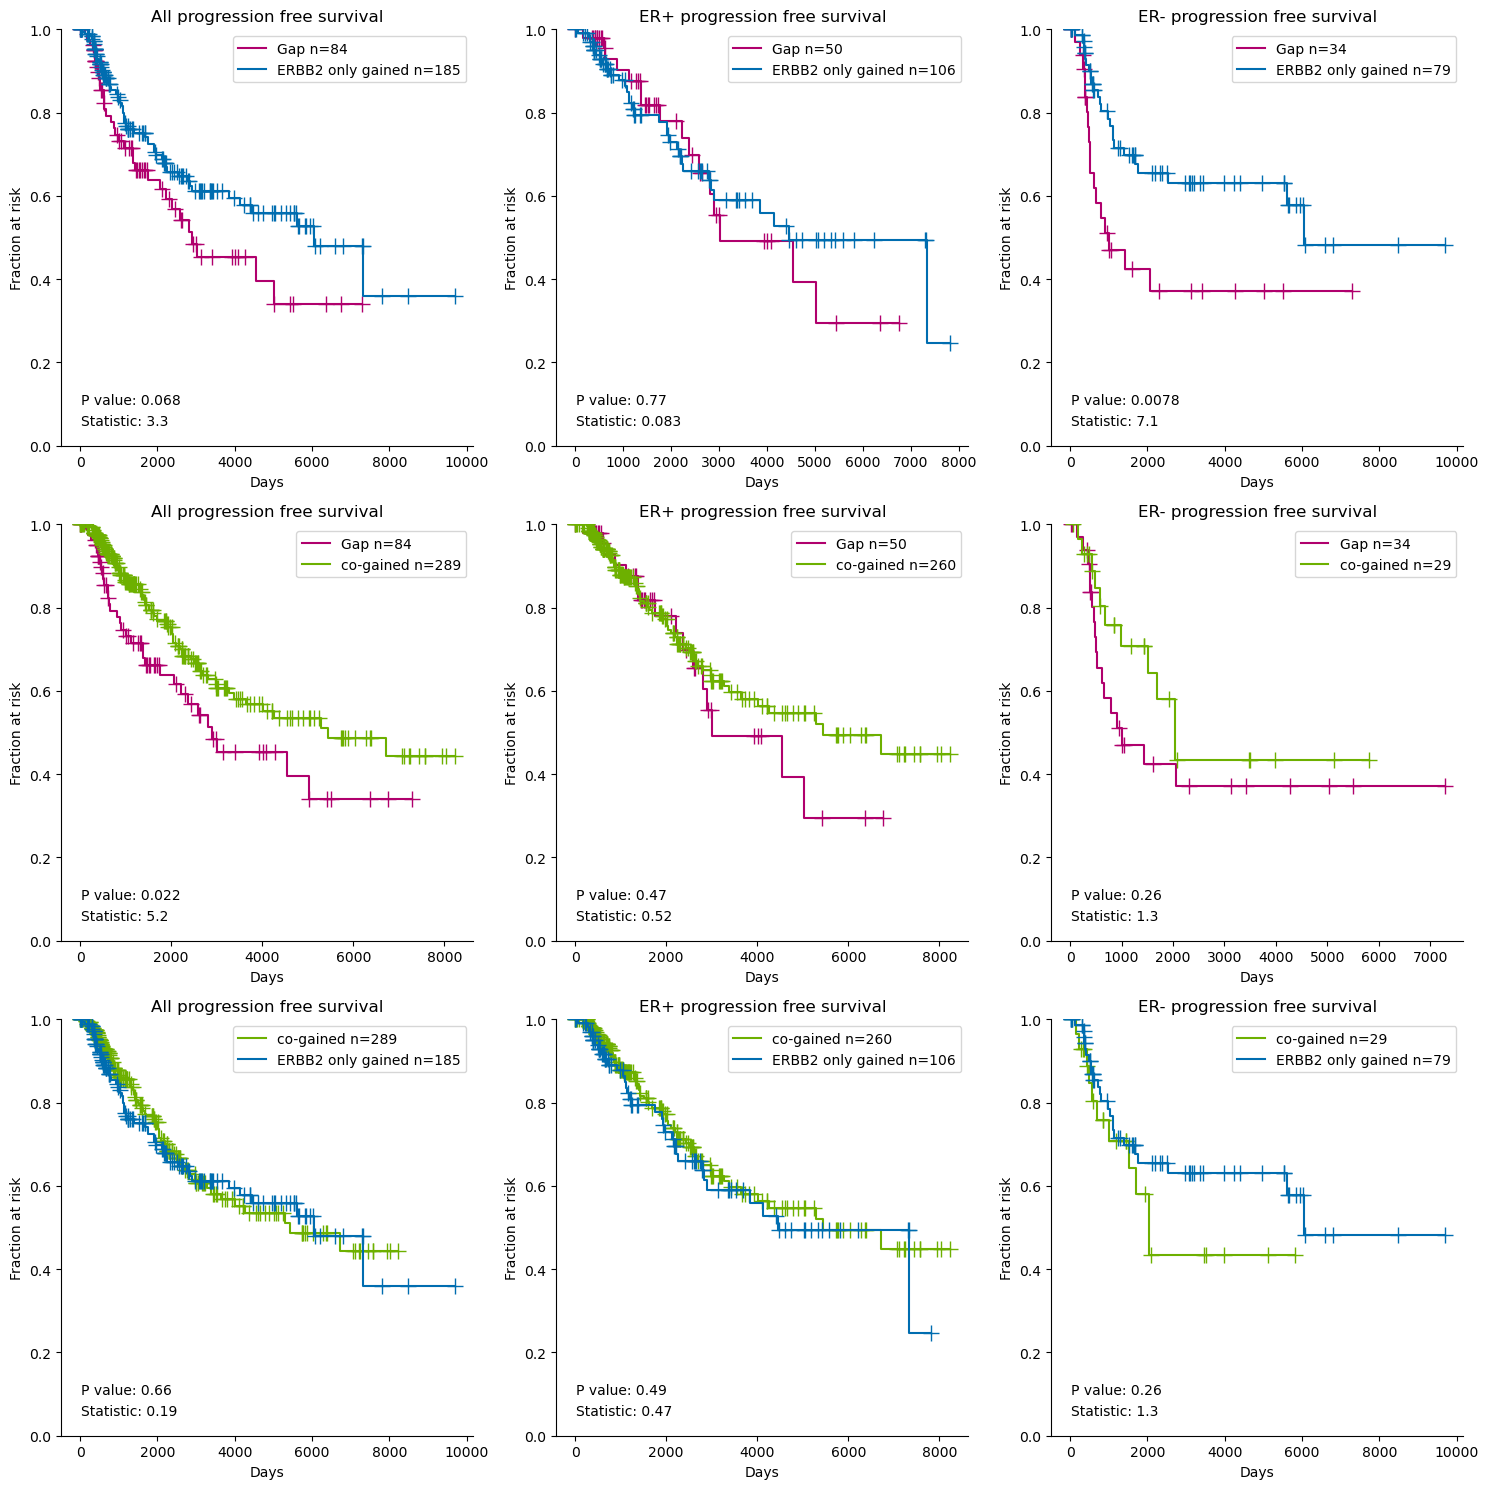

In [31]:
#Figure 6AB - Survival analyses on overall and progression free survival with all three curves together
#this one makes the pairwise p values
fig, axarr = plt.subplots(3, 3, figsize=(15, 15))
pairing_list_1 = ["Gap", "Gap", "Gap", "Gap", "Gap", "Gap", 'co-gained', 'co-gained', 'co-gained', "Gap", "Gap", "Gap"]
pairing_list_2 = ["ERBB2 only gained", "ERBB2 only gained", "ERBB2 only gained", 'co-gained', 'co-gained', 'co-gained', "ERBB2 only gained", "ERBB2 only gained", "ERBB2 only gained"]
color_list_1 = ["#b0006d", "#b0006d", "#b0006d", "#b0006d", "#b0006d", "#b0006d", '#6db000', '#6db000', '#6db000', "#b0006d", "#b0006d", "#b0006d"]
color_list_2 = ["#006db0", "#006db0", "#006db0", '#6db000', '#6db000', '#6db000', "#006db0", "#006db0", "#006db0", "#787096", "#787096", "#787096"]
dataset_list = [all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival, all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival, all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival, all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival]
title_list = ["All progression free survival", "ER+ progression free survival", "ER- progression free survival", "All progression free survival", "ER+ progression free survival", "ER- progression free survival","All progression free survival", "ER+ progression free survival", "ER- progression free survival", "All progression free survival", "ER+ progression free survival", "ER- progression free survival"]
pairwise_pval_list = []

list_counter = 0
for x in range (0, 3):
    for y in range (0, 3):
        first_group = pairing_list_1[list_counter]
        second_group = pairing_list_2[list_counter]
        chosen_dataset = dataset_list[list_counter]
        title_name = title_list[list_counter]
        plt.sca(axarr[x, y])
        T = chosen_dataset['PFI.time']
        E = chosen_dataset['PFI']
        kmf1 = KaplanMeierFitter();
        groups = chosen_dataset['Status']   
        i1 = (groups == first_group);
        i2 = (groups == second_group);     
        kmf1.fit(T[i1], E[i1], label=first_group);
        median_ = kmf1.median_survival_time_
        print("Median survival for", first_group, median_)
        
        a1 = kmf1.plot(show_censors=True, ci_show=False, color = color_list_1[list_counter]);
        kmf1.fit(T[i2], E[i2], label=second_group);
        kmf1.plot(ax=a1, show_censors=True, ci_show=False, color = color_list_2[list_counter]);
        median_ = kmf1.median_survival_time_
        print("Median survival for", second_group, median_)
        
        plt.xlabel("Days")
        plt.ylim(0,1)
        plt.ylabel("Fraction at risk")
        plt.title(title_name)
        plt.legend(["_nolegend_", first_group + " n=" + str(len(E[i1])), "_nolegend_", second_group + " n=" + str(len(E[i2]))])
        results = logrank_test(T[i1], T[i2], E[i1], E[i2], alpha=0.05)
        plt.text(10, 0.1, "P value: " + str("{:.2}".format(results.p_value)))
        plt.text(10, 0.05, "Statistic: " + str("{:.2}".format(results.test_statistic)))
        
        print("Pairwise p value for", first_group, "vs", second_group, ":", str("{:.2}".format(results.p_value)))
        pairwise_pval_list.append(str(first_group + " vs " + second_group + ": " + str("{:.2}".format(results.p_value))))
        list_counter = list_counter+1
        
pairwise_pval_list

Median survival for Gap 4349.5833381
Median survival for ERBB2 only gained 4098.138892366111
Median survival for co-gained 4409.402783623888
Median survival for Gap 5500.347227236111
Median survival for ERBB2 only gained 3893.3333376
Median survival for co-gained 4545.263892856111
Median survival for Gap 1692.180557308611
Median survival for ERBB2 only gained 5978.902785343889
Median survival for co-gained 3063.0
Median survival for Gap 2893.537503171
Median survival for ERBB2 only gained 6058.3916733060005
Median survival for co-gained 5440.933339296
Median survival for Gap 3014.0
Median survival for ERBB2 only gained 4456.0
Median survival for co-gained 5440.933339296
Median survival for Gap 998.579167761
Median survival for ERBB2 only gained 6058.3916733060005
Median survival for co-gained 2041.0


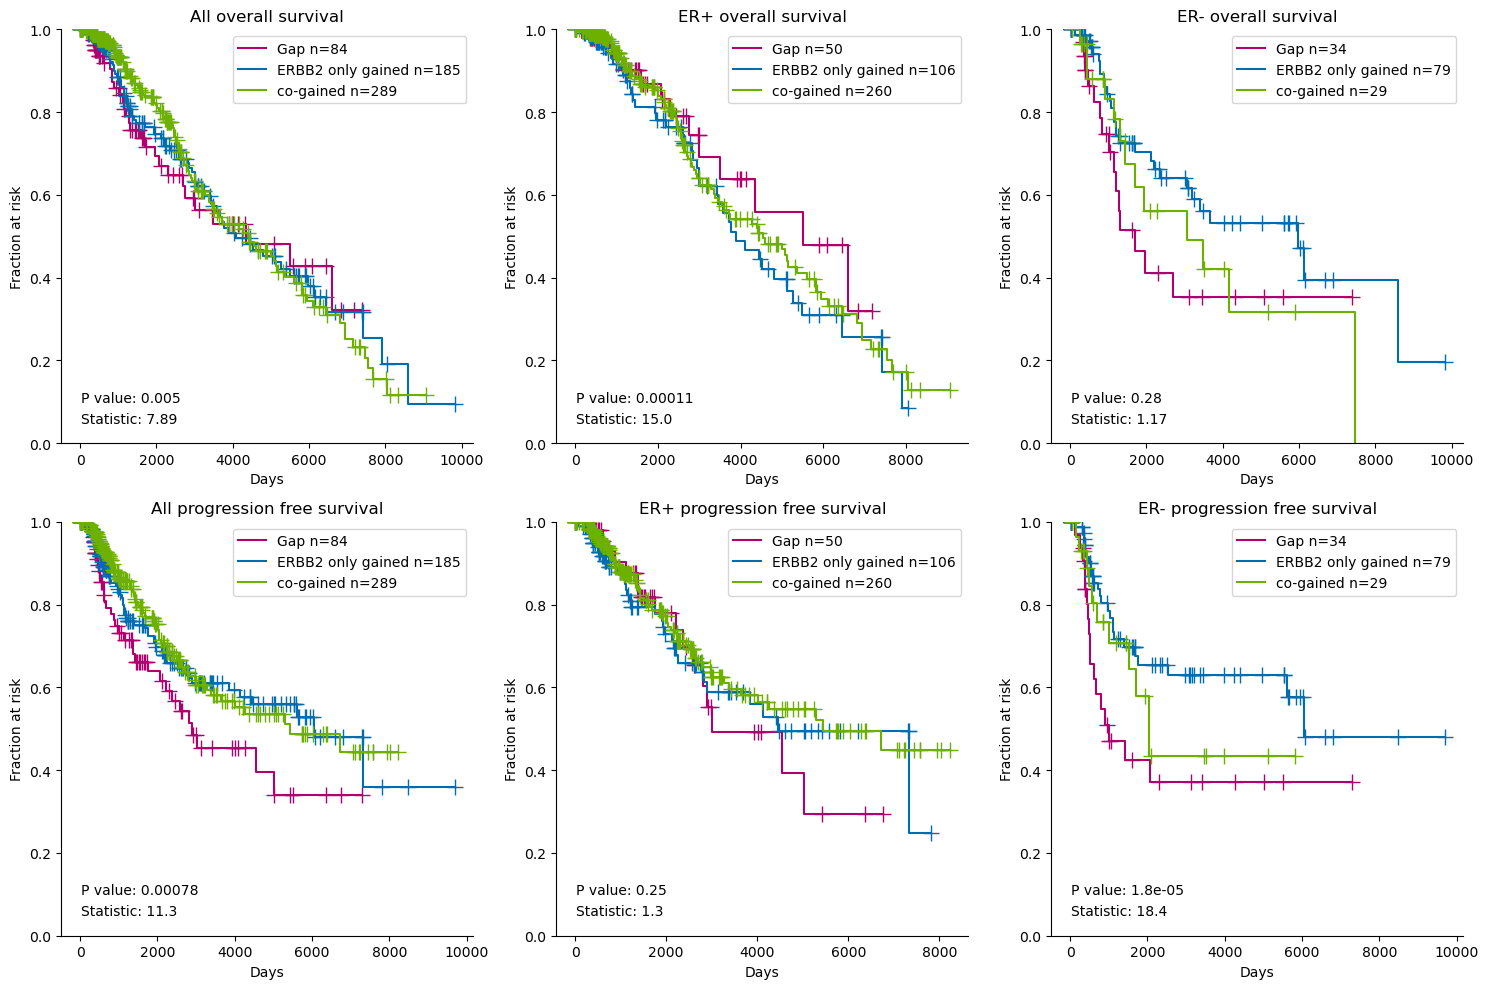

In [32]:
#Figure 6AB - Survival analyses on overall and progression free survival with all three curves together
fig, axarr = plt.subplots(2, 3, figsize=(15, 10))
dataset_list = [all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival, all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival]
title_list = ["All overall survival", "ER+ overall survival", "ER- overall survival", "All progression free survival", "ER+ progression free survival", "ER- progression free survival"]
time_list = ["OS.time", "OS.time","OS.time", "PFI.time","PFI.time", "PFI.time"]
event_list = ["OS", "OS", "OS", "PFI", "PFI", "PFI"]

list_counter = 0
for x in range (0, 2):
    for y in range (0, 3):
        chosen_dataset = dataset_list[list_counter]
        title_name = title_list[list_counter]
        plt.sca(axarr[x,y])
        T = chosen_dataset[time_list[list_counter]]
        E = chosen_dataset[event_list[list_counter]]
        kmf1 = KaplanMeierFitter();
        groups = chosen_dataset['Status']   
        i1 = (groups == "Gap");
        i2 = (groups == "ERBB2 only gained");     
        i3 = (groups == "co-gained"); 
        i4 = (groups == "Gap without HOX"); 
        kmf1.fit(T[i1], E[i1], label="Gap");
        a1 = kmf1.plot(show_censors=True, ci_show=False, color = "#b0006d");
        median_ = kmf1.median_survival_time_
        print("Median survival for Gap", median_)
        
        kmf1.fit(T[i2], E[i2], label="ERBB2 only gained");
        a2 = kmf1.plot(show_censors=True, ci_show=False, color = "#006db0");
        median_ = kmf1.median_survival_time_
        print("Median survival for ERBB2 only gained", median_)
        
        kmf1.fit(T[i3], E[i3], label="co-gained");
        a3 = kmf1.plot(show_censors=True, ci_show=False, color = "#6db000");
        median_ = kmf1.median_survival_time_
        print("Median survival for co-gained", median_)
        
        plt.xlabel("Days")
        plt.ylim(0,1)
        plt.ylabel("Fraction at risk")
        plt.title(title_name)
        plt.legend(["_nolegend_", "Gap n=" + str(len(E[i1])), "_nolegend_", "ERBB2 only gained n=" + str(len(E[i2])), "_nolegend_", "co-gained n=" + str(len(E[i3])), "_nolegend_", "Gap without HOX n=" + str(len(E[i4]))])
        results = multivariate_logrank_test(T, E, chosen_dataset["Status"] , alpha=0.05)
        plt.text(10, 0.1, "P value: " + str("{:.2}".format(results.p_value)))
        plt.text(10, 0.05, "Statistic: " + str("{:.3}".format(results.test_statistic)))
        
        list_counter = list_counter+1
        


Median survival for Gap 2893.537503171
Median survival for ERBB2 only gained 6058.3916733060005
Median survival for co-gained 5440.933339296
Median survival for Gap 3014.0
Median survival for ERBB2 only gained 4456.0
Median survival for co-gained 5440.933339296
Median survival for Gap 998.579167761
Median survival for ERBB2 only gained 6058.3916733060005
Median survival for co-gained 2041.0


INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 44 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'D', 'E', 'F', 'G', 'R', 'a', 'c', 'colon', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 36, 37, 39, 40, 41, 42, 53, 68, 70, 71, 72, 73, 74, 76, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89, 92]
INFO - Closed glyph list over 'GSUB': 49 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'D', 'E', 'F', 'G', 'R', 'a', 'c', 'colon', 'd', 'e', 'eight', 'equal', 'f', 'fi', 'five', 'fl', 'four

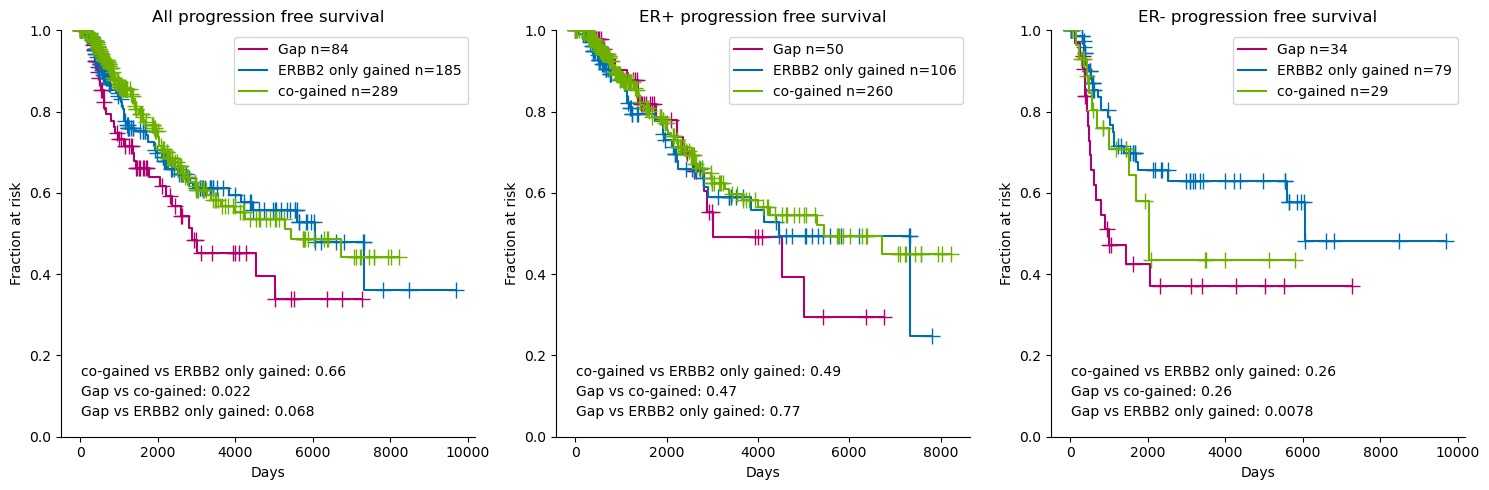

In [33]:
#merging the previous two so that all three curves are shown
#but the p values are pairwise
#Figure 6AB - Survival analyses on overall and progression free survival with all three curves together
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
dataset_list = [all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival]
title_list = ["All progression free survival", "ER+ progression free survival", "ER- progression free survival"]
time_list = ["PFI.time","PFI.time", "PFI.time"]
event_list = ["PFI", "PFI", "PFI"]

list_counter = 0
for y in range (0, 3):
        chosen_dataset = dataset_list[list_counter]
        title_name = title_list[list_counter]
        plt.sca(axarr[y])
        T = chosen_dataset[time_list[list_counter]]
        E = chosen_dataset[event_list[list_counter]]
        kmf1 = KaplanMeierFitter();
        groups = chosen_dataset['Status']   
        i1 = (groups == "Gap");
        i2 = (groups == "ERBB2 only gained");     
        i3 = (groups == "co-gained"); 
        i4 = (groups == "Gap without HOX"); 
        kmf1.fit(T[i1], E[i1], label="Gap");
        a1 = kmf1.plot(show_censors=True, ci_show=False, color = "#b0006d");
        median_ = kmf1.median_survival_time_
        print("Median survival for Gap", median_)
        
        kmf1.fit(T[i2], E[i2], label="ERBB2 only gained");
        a2 = kmf1.plot(show_censors=True, ci_show=False, color = "#006db0");
        median_ = kmf1.median_survival_time_
        print("Median survival for ERBB2 only gained", median_)
        
        kmf1.fit(T[i3], E[i3], label="co-gained");
        a3 = kmf1.plot(show_censors=True, ci_show=False, color = "#6db000");
        median_ = kmf1.median_survival_time_
        print("Median survival for co-gained", median_)
        
        plt.xlabel("Days")
        plt.ylim(0,1)
        plt.ylabel("Fraction at risk")
        plt.title(title_name)
        plt.legend(["_nolegend_", "Gap n=" + str(len(E[i1])), "_nolegend_", "ERBB2 only gained n=" + str(len(E[i2])), "_nolegend_", "co-gained n=" + str(len(E[i3])), "_nolegend_", "Gap without HOX n=" + str(len(E[i4]))])
        results = multivariate_logrank_test(T, E, chosen_dataset["Status"] , alpha=0.05)
        plt.text(10, 0.05, pairwise_pval_list[0 + y])
        plt.text(10, 0.1, pairwise_pval_list[3 + y])
        plt.text(10, 0.15, pairwise_pval_list[6 + y])
        
        list_counter = list_counter+1
        


plt.savefig('Figures/Figure6AB.pdf')


INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 41 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'G', 'H', 'I', 'L', 'N', 'O', 'R', 'S', 'X', 'a', 'c', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'plus', 'r', 's', 'seven', 'slash', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 18, 19, 20, 21, 22, 24, 26, 36, 37, 40, 42, 43, 44, 47, 49, 50, 53, 54, 59, 68, 70, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92, 3228]
INFO - Closed glyph list over 'GSUB': 41 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'G', 'H', 'I', 'L', 'N', 'O', 'R', 'S', 'X', 'a', 'c', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'o

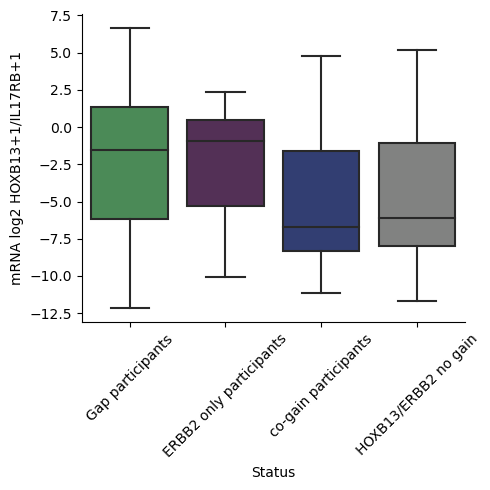

In [34]:
#FIGURE 6C
#HOXB13/IL17RB mRNA for the various groups with ER+/ER- split for each group
#making temporary dataframe to annotate
boxplot_palette = ["#419450", "#592A5C", "#28387C", "#818281"]
TCGA_BRCA_mRNA_tumor_data.loc["HOXB13/IL17RB"] = TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]/TCGA_BRCA_mRNA_tumor_data.loc["IL17RB"]
Figure6C_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#adding 1 to IL17RB and HOXB13 to avoid dividng by zero errors
Figure6C_tempdf.loc["log2 HOXB13/IL17RB"] = np.log2((Figure6C_tempdf.loc["HOXB13"] + 1)/(Figure6C_tempdf.loc["IL17RB"] + 1))
Figure6C_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)

Figure6C_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2 only participants"
Figure6C_tempdf.loc["Status", TCGA_BRCA_co_gained_participants] = "co-gain participants"
Figure6C_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap participants"

group_order = ["Gap participants", "ERBB2 only participants", "co-gain participants", "HOXB13/ERBB2 no gain", ]
sns.boxplot(palette = boxplot_palette, order = group_order, y = Figure6C_tempdf.loc["log2 HOXB13/IL17RB"], x = Figure6C_tempdf.loc["Status"])
ax.set_ylabel("mRNA log2 HOXB13+1/IL17RB+1")

#make list of all pairwise p vals here
p_val_table = pd.DataFrame(columns = group_order, index = group_order)
for x in group_order:
    for y in group_order:
        if (x != y):
            p_val_table.loc[x, y] = mannwhitneyu(list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == x].loc["HOXB13/IL17RB"].dropna()), list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == y].loc["HOXB13/IL17RB"].dropna()))[1]

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
p_val_table.to_csv("Figures/Figure6C_pairwisepvals.txt", sep = "\t")
plt.savefig('Figures/Figure6C.pdf')

In [35]:
p_val_table

,Gap participants,ERBB2 only participants,co-gain participants,HOXB13/ERBB2 no gain
Gap participants,NaN,0.680032,0.00004,0.000045
ERBB2 only participants,0.680032,NaN,0.000001,0.0
co-gain participants,0.00004,0.000001,NaN,0.446862
HOXB13/ERBB2 no gain,0.000045,0.0,0.446862,NaN


INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 40 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'X', 'a', 'e', 'eight', 'equal', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'nonmarkingreturn', 'o', 'one', 'period', 'plus', 's', 'seven', 'slash', 'space', 't', 'three', 'two', 'u', 'v', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 32, 36, 37, 40, 43, 44, 47, 49, 50, 51, 53, 59, 68, 72, 74, 76, 79, 80, 82, 86, 87, 88, 89, 3228]
INFO - Closed glyph list over 'GSUB': 40 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'X', 'a', 'e', 'eight', 'equal', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'nonmarki

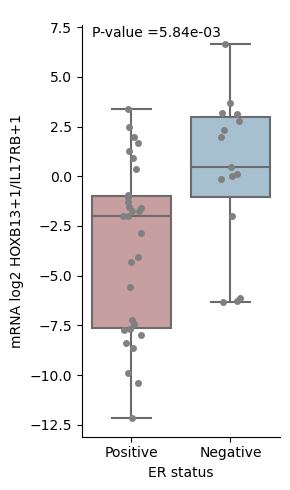

In [36]:
#Figure 6D - ER+ vs - for HOXB13/IL17RB ratio for only gap tumors
Figure6D_tempdf = Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == "Gap participants"]

Figure6D_tempdf.loc["ER status"] = "NaN"
Figure6D_tempdf.loc["ER status", (set(Figure6D_tempdf.columns) & set(TCGA_BRCA_ERpos_participants))] = "Positive"
Figure6D_tempdf.loc["ER status", set(Figure6D_tempdf.columns) & set(TCGA_BRCA_ERneg_participants)] = "Negative"

#dropping those with no ER IHC listed
Figure6D_tempdf = Figure6D_tempdf.loc[:, (Figure6D_tempdf.loc["ER status"] == "Positive") | (Figure6D_tempdf.loc["ER status"] == "Negative")]

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
figure6D_palette = ["#CE989A", "#A0C2D7"]
sns.boxplot(palette = figure6D_palette, y = Figure6D_tempdf.loc["log2 HOXB13/IL17RB"], x = Figure6D_tempdf.loc["ER status"])
sns.stripplot(color = "grey", y = Figure6D_tempdf.loc["log2 HOXB13/IL17RB"], x = Figure6D_tempdf.loc["ER status"])

ax.text(-0.4, 7, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(Figure6D_tempdf.loc["log2 HOXB13/IL17RB", (Figure6D_tempdf.loc["ER status"] == "Positive")]), list(Figure6D_tempdf.loc["log2 HOXB13/IL17RB", (Figure6D_tempdf.loc["ER status"] == "Negative")]))[1])));

ax.set_ylabel("mRNA log2 HOXB13+1/IL17RB+1")
plt.savefig('Figures/Figure6D.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 38 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'G', 'H', 'N', 'O', 'R', 'S', 'X', 'a', 'c', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'plus', 'r', 's', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 18, 19, 20, 21, 22, 23, 25, 27, 36, 37, 40, 42, 43, 49, 50, 53, 54, 59, 68, 70, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO - Closed glyph list over 'GSUB': 38 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'G', 'H', 'N', 'O', 'R', 'S', 'X', 'a', 'c', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'plus', 'r', 's', 'six', 'slash', 's

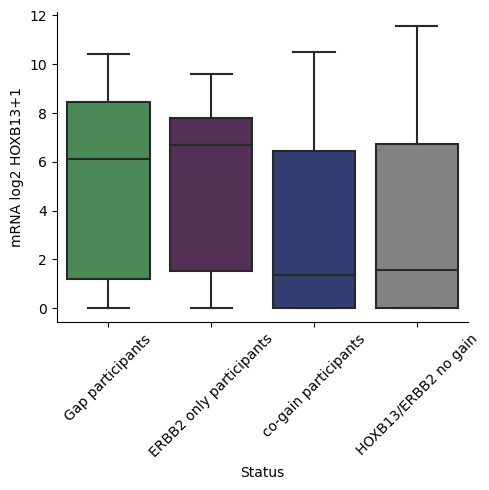

In [37]:
#repeating this figure for HOXB13 only not HOXB13/IL17RB

#temp FIGURE 6C
#HOXB13 mRNA for the various groups with ER+/ER- split for each group
#making temporary dataframe to annotate
boxplot_palette = ["#419450", "#592A5C", "#28387C", "#818281"]
Figure6C_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#adding 1 to HOXB13 to avoid the very small numbers giving large negative values
Figure6C_tempdf.loc["log2 HOXB13"] = np.log2((Figure6C_tempdf.loc["HOXB13"] + 1))
Figure6C_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)

Figure6C_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2 only participants"
Figure6C_tempdf.loc["Status", TCGA_BRCA_co_gained_participants] = "co-gain participants"
Figure6C_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap participants"

group_order = ["Gap participants", "ERBB2 only participants", "co-gain participants", "HOXB13/ERBB2 no gain", ]
sns.boxplot(palette = boxplot_palette, order = group_order, y = Figure6C_tempdf.loc["log2 HOXB13"], x = Figure6C_tempdf.loc["Status"])
ax.set_ylabel("mRNA log2 HOXB13+1")

#make list of all pairwise p vals here
p_val_table = pd.DataFrame(columns = group_order, index = group_order)
for x in group_order:
    for y in group_order:
        if (x != y):
            p_val_table.loc[x, y] = mannwhitneyu(list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == x].loc["HOXB13"].dropna()), list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == y].loc["HOXB13"].dropna()))[1]

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
p_val_table.to_csv("Figures/temp_Figure6C_pairwisepvals.txt", sep = "\t")
plt.savefig('Figures/temp_Figure6C.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 35 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'H', 'N', 'O', 'P', 'R', 'X', 'a', 'e', 'eight', 'equal', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'nonmarkingreturn', 'o', 'one', 'period', 'plus', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 19, 20, 21, 22, 23, 25, 27, 32, 36, 37, 40, 43, 49, 50, 51, 53, 59, 68, 72, 74, 76, 79, 80, 82, 86, 87, 88, 89]
INFO - Closed glyph list over 'GSUB': 35 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'H', 'N', 'O', 'P', 'R', 'X', 'a', 'e', 'eight', 'equal', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'nonmarkingreturn', 'o', 'one', 'period', 'plus', 's', 'six', 'space', 't', 'three', 'two', 'u',

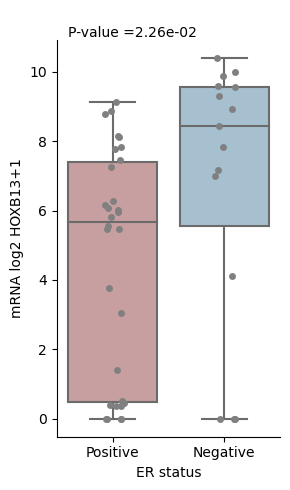

In [38]:
#repeating this figure for HOXB13 only not HOXB13/IL17RB

#Figure 6D - ER+ vs - for HOXB13 for only gap tumors
Figure6D_tempdf = Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == "Gap participants"]

Figure6D_tempdf.loc["ER status"] = "NaN"
Figure6D_tempdf.loc["ER status", (set(Figure6D_tempdf.columns) & set(TCGA_BRCA_ERpos_participants))] = "Positive"
Figure6D_tempdf.loc["ER status", set(Figure6D_tempdf.columns) & set(TCGA_BRCA_ERneg_participants)] = "Negative"

#dropping those with no ER IHC listed
Figure6D_tempdf = Figure6D_tempdf.loc[:, (Figure6D_tempdf.loc["ER status"] == "Positive") | (Figure6D_tempdf.loc["ER status"] == "Negative")]

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
figure6D_palette = ["#CE989A", "#A0C2D7"]
sns.boxplot(palette = figure6D_palette, y = Figure6D_tempdf.loc["log2 HOXB13"], x = Figure6D_tempdf.loc["ER status"])
sns.stripplot(color = "grey", y = Figure6D_tempdf.loc["log2 HOXB13"], x = Figure6D_tempdf.loc["ER status"])

ax.text(-0.4, 11, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(Figure6D_tempdf.loc["log2 HOXB13", (Figure6D_tempdf.loc["ER status"] == "Positive")]), list(Figure6D_tempdf.loc["log2 HOXB13", (Figure6D_tempdf.loc["ER status"] == "Negative")]))[1])));

ax.set_ylabel("mRNA log2 HOXB13+1")
plt.savefig('Figures/temp_Figure6D.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 47 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'G', 'H', 'I', 'N', 'O', 'P', 'R', 'S', 'X', 'a', 'c', 'e', 'eight', 'equal', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'plus', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 11, 12, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 32, 36, 37, 38, 40, 42, 43, 44, 49, 50, 51, 53, 54, 59, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
INFO - Closed glyph list over 'GSUB': 47 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'G', 'H', 'I', 'N', 'O', 'P', 'R', 'S', 'X', 'a', 'c', 'e',

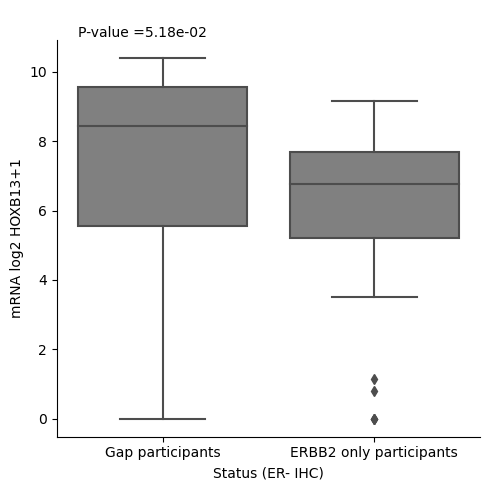

In [39]:
#temp figure 6E
#ERBB2-only vs gap ER- for HOXB13 expression

#repeating this figure for HOXB13 only not HOXB13/IL17RB

#temp FIGURE 6C
#HOXB13 mRNA for the various groups with ER+/ER- split for each group
#making temporary dataframe to annotate
boxplot_palette = ["#419450", "#592A5C", "#28387C", "#818281"]
Figure6E_tempdf = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_ERneg_participants].copy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#adding 1 to HOXB13 to avoid the very small numbers giving large negative values
Figure6E_tempdf.loc["log2 HOXB13"] = np.log2((Figure6E_tempdf.loc["HOXB13"] + 1))
Figure6E_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)

Figure6E_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2 only participants"
Figure6E_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap participants"

group_order = ["Gap participants", "ERBB2 only participants"]
sns.boxplot(order = group_order, y = Figure6E_tempdf.loc["log2 HOXB13"], x = Figure6E_tempdf.loc["Status"], color = "grey")
ax.set_ylabel("mRNA log2 HOXB13+1")
ax.set_xlabel("Status (ER- IHC)")
ax.text(-0.4, 11, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(Figure6E_tempdf.loc["log2 HOXB13", TCGA_BRCA_ERBB2only_participants].dropna()), list(Figure6E_tempdf.loc["log2 HOXB13", TCGA_BRCA_gap_participants].dropna()))[1])));


plt.savefig('Figures/temp_Figure6E.pdf')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 43 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'E', 'F', 'H', 'O', 'R', 'X', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'percent', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 8, 16, 17, 19, 20, 21, 22, 23, 25, 27, 28, 29, 37, 40, 41, 43, 50, 53, 59, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
INFO - Closed glyph list over 'GSUB': 48 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'E', 'F', 'H', 'O', 'R', 'X', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l

ERBB2 Chi squared p value: 3.198520948501472e-36
HOXB13 Chi squared p value: 0.00029496094670980553


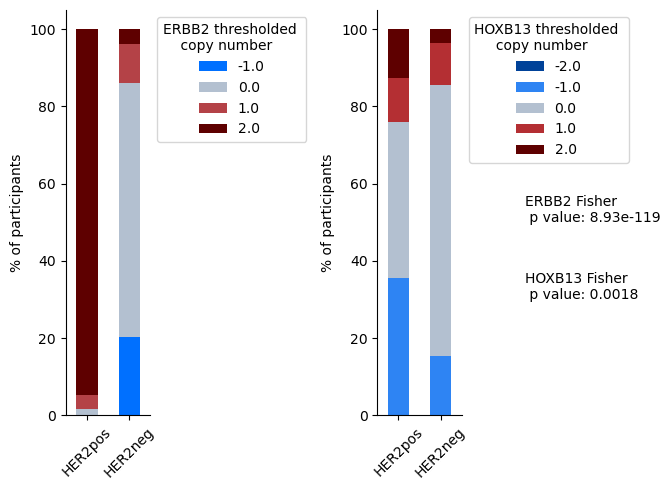

In [40]:
#Supplemental Figure 1A and B
#redoing previous figure but with METABRIC data
#moving around the METABRIC data
segmented_METABRIC_copynumber_data  = METABRIC_copynumber_data.copy()
segmented_METABRIC_copynumber_data_HOXB13 = pd.DataFrame(segmented_METABRIC_copynumber_data.loc["HOXB13"])
segmented_METABRIC_copynumber_data_HOXB13.columns = ["Copy number"]
segmented_METABRIC_copynumber_data_HOXB13["Gene name"] = "HOXB13"
segmented_METABRIC_copynumber_data_HOXB13.loc[METABRIC_HER2pos_participants, "HER2 status"] = "Pos"
segmented_METABRIC_copynumber_data_HOXB13.loc[METABRIC_HER2neg_participants, "HER2 status"] = "Neg"

segmented_METABRIC_copynumber_data_ERBB2 = pd.DataFrame(segmented_METABRIC_copynumber_data.loc["ERBB2"])
segmented_METABRIC_copynumber_data_ERBB2.columns = ["Copy number"]
segmented_METABRIC_copynumber_data_ERBB2["Gene name"] = "ERBB2"
segmented_METABRIC_copynumber_data_ERBB2.loc[METABRIC_HER2pos_participants, "HER2 status"] = "Pos"
segmented_METABRIC_copynumber_data_ERBB2.loc[METABRIC_HER2neg_participants, "HER2 status"] = "Neg"

ERBB2_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0070FF","#B3C0D0", "#B3C0D0", "#B40303", "#5E0000"])
HOXB13_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#004299", "#0070FF", "#B3C0D0", "#B3C0D0", "#B40303", "#5E0000"])


suppfig1tempdf_ERBB2 = segmented_METABRIC_copynumber_data_ERBB2.copy()
suppfig1tempdf_HOXB13 = segmented_METABRIC_copynumber_data_HOXB13.copy()
        
fig, ax = plt.subplots(1, 2, figsize=(7, 5))
plt.rcParams['pdf.fonttype'] = 42
suppfig1temp_HER2pos_ERBB2 = pd.DataFrame(suppfig1tempdf_ERBB2.loc[suppfig1tempdf_ERBB2.loc[:, "HER2 status"] == "Pos"].loc[:, "Copy number"].value_counts())
suppfig1temp_HER2pos_ERBB2.columns = ["HER2pos"]
#for statistics later
notpercent_suppfig1temp_HER2pos_ERBB2 = suppfig1temp_HER2pos_ERBB2.copy()
#making everything fractions
suppfig1temp_HER2pos_ERBB2["HER2pos"] = suppfig1temp_HER2pos_ERBB2["HER2pos"]/sum(suppfig1temp_HER2pos_ERBB2["HER2pos"])
suppfig1temp_HER2neg_ERBB2 = pd.DataFrame(suppfig1tempdf_ERBB2.loc[suppfig1tempdf_ERBB2.loc[:, "HER2 status"] == "Neg"].loc[:, "Copy number"].value_counts())
suppfig1temp_HER2neg_ERBB2.columns = ["HER2neg"]
#for statistics later
notpercent_suppfig1temp_HER2neg_ERBB2 = suppfig1temp_HER2neg_ERBB2.copy()
suppfig1temp_HER2neg_ERBB2["HER2neg"] = suppfig1temp_HER2neg_ERBB2["HER2neg"]/sum(suppfig1temp_HER2neg_ERBB2["HER2neg"])
final_suppfig1tempdf_ERBB2 = pd.concat([suppfig1temp_HER2pos_ERBB2, suppfig1temp_HER2neg_ERBB2], axis = 1).transpose()

#removing the participants in the middle for the figure since they are so few it doesn't impact the graphics
final_suppfig1tempdf_ERBB2 = final_suppfig1tempdf_ERBB2[[-1,0,1,2]]
final_suppfig1tempdf_ERBB2 = final_suppfig1tempdf_ERBB2*100
final_suppfig1tempdf_ERBB2.plot(kind='bar', stacked=True, ax = ax[0], colormap = ERBB2_palette)
ax[0].set_ylabel('% of participants')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].legend(bbox_to_anchor=(1.0, 1.0), title="ERBB2 thresholded \n    copy number")


suppfig1temp_HER2pos_HOXB13 = pd.DataFrame(suppfig1tempdf_HOXB13.loc[suppfig1tempdf_HOXB13.loc[:, "HER2 status"] == "Pos"].loc[:, "Copy number"].value_counts())
suppfig1temp_HER2pos_HOXB13.columns = ["HER2pos"]
#for statistics later
notpercent_suppfig1temp_HER2pos_HOXB13 = suppfig1temp_HER2pos_HOXB13.copy()
#making everything fractions
suppfig1temp_HER2pos_HOXB13["HER2pos"] = suppfig1temp_HER2pos_HOXB13["HER2pos"]/sum(suppfig1temp_HER2pos_HOXB13["HER2pos"])
suppfig1temp_HER2neg_HOXB13 = pd.DataFrame(suppfig1tempdf_HOXB13.loc[suppfig1tempdf_HOXB13.loc[:, "HER2 status"] == "Neg"].loc[:, "Copy number"].value_counts())
suppfig1temp_HER2neg_HOXB13.columns = ["HER2neg"]
#for statistics later
notpercent_suppfig1temp_HER2neg_HOXB13 = suppfig1temp_HER2neg_HOXB13.copy()
suppfig1temp_HER2neg_HOXB13["HER2neg"] = suppfig1temp_HER2neg_HOXB13["HER2neg"]/sum(suppfig1temp_HER2neg_HOXB13["HER2neg"])
final_suppfig1tempdf_HOXB13 = pd.concat([suppfig1temp_HER2pos_HOXB13, suppfig1temp_HER2neg_HOXB13], axis = 1).transpose()

#removing the participants in the middle for the figure since they are so few it doesn't impact the graphics
final_suppfig1tempdf_HOXB13 = final_suppfig1tempdf_HOXB13[[-2,-1,0,1,2]]
final_suppfig1tempdf_HOXB13 = final_suppfig1tempdf_HOXB13*100
final_suppfig1tempdf_HOXB13.plot(kind='bar', stacked=True, ax = ax[1], colormap = HOXB13_palette)
ax[1].set_ylabel('% of participants')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].legend(bbox_to_anchor=(1.0, 1.0), title="HOXB13 thresholded \n     copy number")

#p values
final_suppfig1tempdf_ERBB2 = final_suppfig1tempdf_ERBB2.fillna(0)
stat, p, dof, expected = chi2_contingency(final_suppfig1tempdf_ERBB2)
print("ERBB2 Chi squared p value:", str(p))
final_suppfig1tempdf_HOXB13 = final_suppfig1tempdf_HOXB13.fillna(0)
stat, p, dof, expected = chi2_contingency(final_suppfig1tempdf_HOXB13)
print("HOXB13 Chi squared p value:", str(p))

#fisher tables
fig2A_ERBB2fisherdf = pd.DataFrame()
fig2A_ERBB2fisherdf.loc["not gained", "HER2+"] = 3
fig2A_ERBB2fisherdf.loc["gained", "HER2+"] = 166+6
fig2A_ERBB2fisherdf.loc["not gained", "HER2-"] = 813+248
fig2A_ERBB2fisherdf.loc["gained", "HER2-"] = 122+48
plt.text(3, 50, "ERBB2 Fisher \n p value: " + str("{:.3}".format(fisher_exact(fig2A_ERBB2fisherdf, alternative='two-sided')[1])))

fig2A_HOXB13fisherdf = pd.DataFrame()
fig2A_HOXB13fisherdf.loc["not gained", "HER2+"] = 71+62
fig2A_HOXB13fisherdf.loc["gained", "HER2+"] = 22+20
fig2A_HOXB13fisherdf.loc["not gained", "HER2-"] = 1+187+865
fig2A_HOXB13fisherdf.loc["gained", "HER2-"] = 134+44
plt.text(3, 30, "HOXB13 Fisher \n p value: " + str("{:.3}".format(fisher_exact(fig2A_HOXB13fisherdf, alternative='two-sided')[1])))


plt.savefig('Figures/Supplemental_Figure1AB.pdf')


INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 43 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'H', 'I', 'M', 'O', 'R', 'T', 'X', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 40, 43, 44, 48, 50, 53, 55, 59, 68, 69, 70, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO - Closed glyph list over 'GSUB': 43 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'H', 'I', 'M', 'O', 'R', 'T', 'X', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n

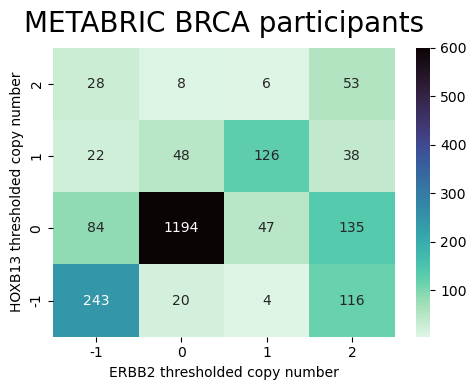

In [41]:
#SUPPLEMENTAL FIGURE 1C
#repeating heatmaps for METABRIC
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
temp_df_erb0 = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 0].columns
temp_df_erbneg1 = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == -1].columns
temp_df_erb1 = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 1].columns
temp_df_erb2 = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 2].columns

temp_fulldfheatmap = pd.DataFrame(data = METABRIC_copynumber_data.loc['HOXB13', temp_df_erb0].value_counts())
temp_fulldfheatmap.columns = ["ERBB2=0"]
temp_fulldfheatmap["ERBB2=1"] = METABRIC_copynumber_data.loc['HOXB13', temp_df_erb1].value_counts()
temp_fulldfheatmap["ERBB2=-1"] = METABRIC_copynumber_data.loc['HOXB13', temp_df_erbneg1].value_counts()
temp_fulldfheatmap["ERBB2=2"] = METABRIC_copynumber_data.loc['HOXB13', temp_df_erb2].value_counts()
temp_fulldfheatmap.index = ["HOXB13=0", "HOXB13=1", "HOXB13=-1", "HOXB13=2"]
temp_fulldfheatmap = temp_fulldfheatmap.loc[["HOXB13=2", "HOXB13=1", "HOXB13=0", "HOXB13=-1"]]
temp_fulldfheatmap = temp_fulldfheatmap[["ERBB2=-1", "ERBB2=0", "ERBB2=1", "ERBB2=2"]]

#changing the labels for the heatmap plot
METABRIC_fulldfheatmap_zerolabels = temp_fulldfheatmap.copy()
METABRIC_fulldfheatmap_zerolabels.index = [2, 1, 0, -1]
METABRIC_fulldfheatmap_zerolabels.columns = [-1, 0, 1, 2]
sns.heatmap(data = METABRIC_fulldfheatmap_zerolabels, annot = True, cmap='mako_r', fmt=".0f", ax = ax, vmax = 600)
ax.set_title("METABRIC BRCA participants", y = 1.025, size = 20)
ax.set_ylabel('HOXB13 thresholded copy number')
ax.set_xlabel('ERBB2 thresholded copy number')
plt.savefig('Figures/Supplemental_Figure1C.pdf')



INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 25 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'E', 'H', 'O', 'R', 'X', 'a', 'd', 'e', 'five', 'four', 'g', 'i', 'n', 'nonmarkingreturn', 'o', 'one', 'six', 'space', 't', 'three', 'two', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 37, 40, 43, 50, 53, 59, 68, 71, 72, 74, 76, 81, 82, 87]
INFO - Closed glyph list over 'GSUB': 25 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'E', 'H', 'O', 'R', 'X', 'a', 'd', 'e', 'five', 'four', 'g', 'i', 'n', 'nonmarkingreturn', 'o', 'one', 'six', 'space', 't', 'three', 'two', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 37, 40, 43, 50, 53, 59, 68, 71, 72, 74, 76, 81, 82, 87]
INFO - Closing glyph list over 'MATH': 25 gly

(10.734818193177558, 8.55082495949893e-77)

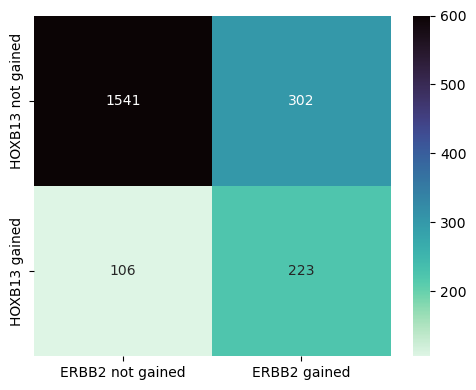

In [42]:
statistics_df2 = pd.DataFrame()
statistics_df2.loc["HOXB13 not gained", "ERBB2 not gained"] = 84+1194+243+20
statistics_df2.loc["HOXB13 gained", "ERBB2 not gained"] = 22+28+48+8
statistics_df2.loc["HOXB13 not gained", "ERBB2 gained"] = 47+135+4+116
statistics_df2.loc["HOXB13 gained", "ERBB2 gained"] = 6+53+126+38

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.heatmap(data = statistics_df2, annot = True, cmap='mako_r', fmt=".0f", ax = ax, vmax = 600)
plt.savefig('Figures/Supplemental_Figure1D.pdf')

fisher_exact(statistics_df2, alternative='two-sided')

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 41 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'G', 'P', 'R', 'T', 'a', 'c', 'e', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'percent', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 8, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 32, 37, 38, 40, 42, 51, 53, 55, 68, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
INFO - Closed glyph list over 'GSUB': 46 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'G', 'P', 'R', 'T', 'a', 'c', 'e', 'equal', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingretur

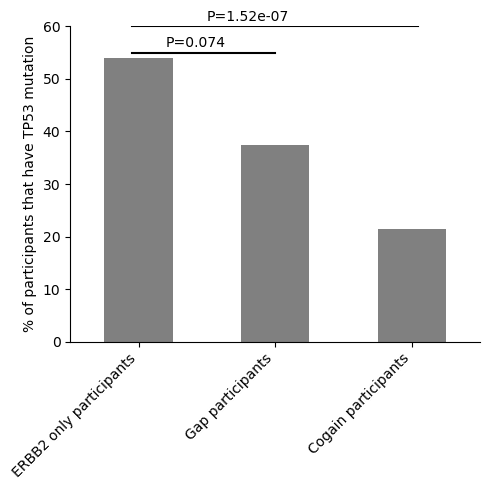

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
TP53_figure_df["% of participants"].plot(kind='bar', color = "grey")
ax.set_ylabel('% of participants that have TP53 mutation')
ax.set_ylim(0, 60)
fig.autofmt_xdate(rotation=45)
#p values
fisher_df_tp53_erbb2vsgap = pd.DataFrame()
fisher_df_tp53_erbb2vsgap.loc["ERBB2only", "TP53 mutated"] = TP53_figure_df.loc["ERBB2 only participants", "Number of participants"]
fisher_df_tp53_erbb2vsgap.loc["ERBB2only", "TP53 not mutated"] = len(TCGA_BRCA_ERBB2only_participants) - TP53_figure_df.loc["ERBB2 only participants", "Number of participants"]
fisher_df_tp53_erbb2vsgap.loc["gap", "TP53 mutated"] = TP53_figure_df.loc["Gap participants", "Number of participants"]
fisher_df_tp53_erbb2vsgap.loc["gap", "TP53 not mutated"] = len(TCGA_BRCA_gap_participants) - TP53_figure_df.loc["Gap participants", "Number of participants"]

ax.axhline(y=55, xmin=0.15, xmax=0.5, color="black")
plt.text(0.2, 56, "P=" + str("{0:.3f}".format(fisher_exact(fisher_df_tp53_erbb2vsgap, alternative='two-sided')[1])))


fisher_df_tp53_erbb2vscogain = pd.DataFrame()
fisher_df_tp53_erbb2vscogain.loc["ERBB2only", "TP53 mutated"] = TP53_figure_df.loc["ERBB2 only participants", "Number of participants"]
fisher_df_tp53_erbb2vscogain.loc["ERBB2only", "TP53 not mutated"] = len(TCGA_BRCA_ERBB2only_participants) - TP53_figure_df.loc["ERBB2 only participants", "Number of participants"]
fisher_df_tp53_erbb2vscogain.loc["cogain", "TP53 mutated"] = TP53_figure_df.loc["Cogain participants", "Number of participants"]
fisher_df_tp53_erbb2vscogain.loc["cogain", "TP53 not mutated"] = len(TCGA_BRCA_co_gained_participants) - TP53_figure_df.loc["Cogain participants", "Number of participants"]
ax.axhline(y=60, xmin=0.15, xmax=0.85, color="black")
plt.text(0.5, 61, "P=" + str("{:.3}".format(fisher_exact(fisher_df_tp53_erbb2vscogain, alternative='two-sided')[1])))


plt.savefig("Figures/Supplemental_Figure2A.pdf")

INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 47 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'G', 'H', 'R', 'a', 'c', 'colon', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 36, 37, 38, 40, 42, 43, 53, 68, 70, 71, 72, 73, 74, 75, 76, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92]
INFO - Closed glyph list over 'GSUB': 52 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'G', 'H', 'R', 'a', 'c', 'colon', 'd', 'e', 'e

Chisquared p value 3.992803433443301e-13


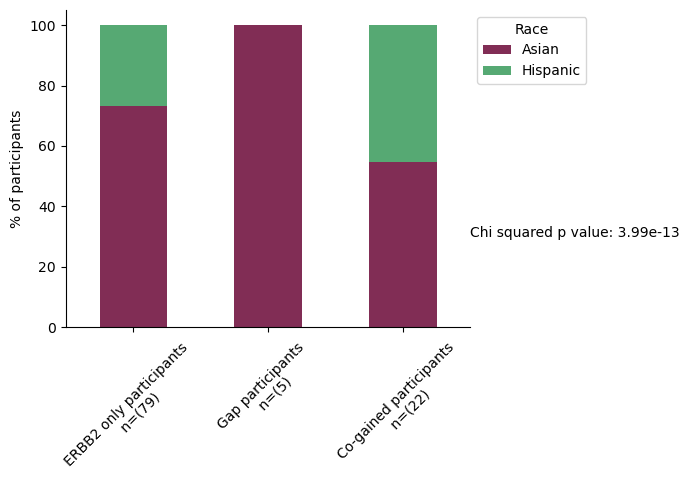

In [44]:
#Supplemental Figure 3
#validating race barplot with DeepDive cohort
deepdive_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#812D55", "#56A973"])

deepdive_clinicalinfo = pd.DataFrame(pd.read_excel("Raw_data/DeepDive/NIHMS890993-supplement-Supplementary_Data.xlsx", index_col = 1))
deepdive_clinicalinfo.index = [str(x) for x in deepdive_clinicalinfo.index]
#dropping the two that are not in gistic
deepdive_clinicalinfo.drop(["nan"], axis = 0, inplace = True)
deepdive_gistic = pd.read_csv("Raw_data/DeepDive/all_thresholded.by_genes.txt", sep = "\t", index_col = 0)
deepdive_gistic = deepdive_gistic.drop(["Cytoband", "Locus ID"], axis = 1)
#mapping is not 1:1 on the names so trying to find it here
#there are two tpyes: those that contain _T and those whose starts match
#first take care of the _T ones
deepdive_gistic.columns = [x.split("_T")[0] for x in deepdive_gistic.columns]
deepdive_temp1 = deepdive_gistic.loc[:, np.in1d(deepdive_gistic.columns, deepdive_clinicalinfo.index)]
#now those whose starts match
deepdive_temp2 = deepdive_gistic.copy()
deepdive_temp2 = deepdive_temp2.drop(deepdive_gistic.loc[:, np.in1d(deepdive_gistic.columns, deepdive_clinicalinfo.index)].columns, axis = 1)
for x in deepdive_temp2.columns:
    for y in deepdive_clinicalinfo.index:
        if y.find(x):
            deepdive_clinicalinfo.loc[y, "dbGAP ID"] = x
            
#concatenating
final_deepdive_gistic = pd.concat([deepdive_temp1, deepdive_temp2], axis = 1)
#annotating
final_deepdive_gistic.loc["Ancestry"] = deepdive_clinicalinfo.transpose().loc["Ancestry"]
deepdive_BRCA_HER_gained_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['ERBB2'] > 0].columns
deepdive_BRCA_HOX_gained_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] > 0].columns
deepdive_BRCA_HER_nongained_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['ERBB2'] < 1].columns
deepdive_BRCA_HOX_nongained_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] < 1].columns
deepdive_BRCA_HOX_amped_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] > 1].columns


deepdive_BRCA_gap_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['ERBB2'] > 0].columns & final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] > 0].columns & final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['BRCA1'] < 0].columns
deepdive_BRCA_ERBB2only_participants = deepdive_BRCA_HER_gained_participants.intersection(deepdive_BRCA_HOX_nongained_participants)
deepdive_BRCA_co_gained_participants = (final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] > 0].columns) & (final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['ERBB2'] > 0].columns) & (final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['BRCA1'] > -1].columns)
deepdive_BRCA_HOXB13only_participants = deepdive_BRCA_HOX_gained_participants.intersection(deepdive_BRCA_HER_nongained_participants)

final_deepdive_gistic.loc["Status", deepdive_BRCA_gap_participants] = "Gap"
final_deepdive_gistic.loc["Status", deepdive_BRCA_co_gained_participants] = "Cogained"
final_deepdive_gistic.loc["Status", deepdive_BRCA_ERBB2only_participants] = "ERBB2 only"

#checking distribution of race across the 3 groups
deepdive_combined_racedf = pd.DataFrame()
deepdive_combined_racedf["ERBB2 only participants"] = final_deepdive_gistic.loc["Ancestry", deepdive_BRCA_ERBB2only_participants].value_counts()
deepdive_combined_racedf["Gap participants"] = final_deepdive_gistic.loc["Ancestry", deepdive_BRCA_gap_participants].value_counts()
deepdive_combined_racedf["Co-gained participants"] = final_deepdive_gistic.loc["Ancestry", deepdive_BRCA_co_gained_participants].value_counts()
deepdive_combined_racedf = deepdive_combined_racedf.fillna(0)
deepdive_combined_racedf = deepdive_combined_racedf.transpose()

#getting % values
for x in range (0, len(deepdive_combined_racedf.index)):
    deepdive_combined_racedf.iloc[x] = (deepdive_combined_racedf.iloc[x] * 100)/deepdive_combined_racedf.iloc[x].sum()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
deepdive_combined_racedf.plot(kind='bar', stacked=True, ax = ax, colormap = deepdive_palette)
plt.xticks(rotation = 45)
ax.set_ylabel('% of participants')
ax.legend(bbox_to_anchor=(1.0, 1.0), title="Race")
#p values
stat, p, dof, expected = chi2_contingency(deepdive_combined_racedf)
print("Chisquared p value", str(p))
plt.text(2.5, 30, "Chi squared p value: " + str("{:.3}".format(p)))
ax.set_xticklabels(['ERBB2 only participants \n n=(' + str(len(deepdive_BRCA_ERBB2only_participants)) + ")", 'Gap participants \n n=(' + str(len(deepdive_BRCA_gap_participants)) + ")", 'Co-gained participants \n n=(' + str(len(deepdive_BRCA_co_gained_participants)) + ")"])


plt.savefig('Figures/Supplemental_Figure3.pdf')

# From here on, the notebook produces relevant statistics for the manuscript

In [45]:
#for manuscript text
finalGISTIC_figure2Atempdf_HOXB13

HOXB13,-1,0,1,2
HER2pos,30.379747,27.848101,25.316456,16.455696
HER2neg,24.725275,50.366300,23.076923,1.831502


In [46]:
#for manuscript text
notpercent_figure2AGISTIC_tempdf_ERBB2_HERpos

,HER2pos
ERBB2,
2,82
0,31
1,23
-1,22


In [47]:
#values needed for manuscript
print("Number of HER2 gained ER+ participants", len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HER_gained_participants)))
print("Number of HER2 gained ER- participants", len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HER_gained_participants)))
print("Number of HOXB13 gained ER+ participants", len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants)))
print("Number of HOXB13 gained ER- participants", len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants)))
print("Number of HOXB13 HER2 cogained ER+ participants", len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants)))
print("Number of HOXB13 HER2 cogained ER- participants", len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants)))

#temporary boxplots for storing data
boxplot_1_data = {'Receptor status': ["Pos", "Neg"], 'Number of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HER_gained_participants)), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HER_gained_participants))], '% of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HER_gained_participants))*100/len(TCGA_BRCA_ERpos_participants), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HER_gained_participants))*100/len(TCGA_BRCA_ERneg_participants)]}
boxplot_1_df = pd.DataFrame (boxplot_1_data, columns = ['Receptor status','Number of participants', '% of participants'])

boxplot_2_data = {'Receptor status': ["Pos", "Neg"], 'Number of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants)), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants))], '% of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants))*100/len(TCGA_BRCA_ERpos_participants), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants))*100/len(TCGA_BRCA_ERneg_participants)]}
boxplot_2_df = pd.DataFrame (boxplot_2_data, columns = ['Receptor status','Number of participants', '% of participants'])

boxplot_3_data = {'Receptor status': ["Pos", "Neg"], 'Number of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants)), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))], '% of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HER_gained_participants) & set(TCGA_BRCA_HOX_gained_participants))*100/len(TCGA_BRCA_ERpos_participants), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HER_gained_participants) & set(TCGA_BRCA_HOX_gained_participants))*100/len(TCGA_BRCA_ERneg_participants)]}
boxplot_3_df = pd.DataFrame (boxplot_3_data, columns = ['Receptor status','Number of participants', '% of participants'])

boxplot_3_df

Number of HER2 gained ER+ participants 235
Number of HER2 gained ER- participants 74
Number of HOXB13 gained ER+ participants 237
Number of HOXB13 gained ER- participants 52
Number of HOXB13 HER2 cogained ER+ participants 185
Number of HOXB13 HER2 cogained ER- participants 38


,Receptor status,Number of participants,% of participants
0,Pos,185,23.536896
1,Neg,38,16.379310


In [48]:
#fisher for the manuscript
fisher_df_1_temp = pd.DataFrame()
fisher_df_1_temp.loc["ER-", "HOX/HER coamp"] = len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))
fisher_df_1_temp.loc["ER+", "HOX/HER coamp"] = len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))
fisher_df_1_temp.loc["ER-", "HOX/HER not coamp"] = len(set(TCGA_BRCA_ERneg_participants)) - len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))
fisher_df_1_temp.loc["ER+", "HOX/HER not coamp"] = len(set(TCGA_BRCA_ERpos_participants)) - len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))

fisher_exact(fisher_df_1_temp, alternative='two-sided')


(0.6363332404569518, 0.02366955904278255)

In [49]:
#for the manuscript
statistics_df1 = pd.DataFrame()
statistics_df1.loc["HOXB13 not gained", "ERBB2 not gained"] = 36+450+175+5
statistics_df1.loc["HOXB13 gained", "ERBB2 not gained"] = 37+17+11+12
statistics_df1.loc["HOXB13 not gained", "ERBB2 gained"] = 15+10+14+48
statistics_df1.loc["HOXB13 gained", "ERBB2 gained"] = 175+27+5+33

fisher_exact(statistics_df1, alternative='two-sided')

(23.8602776533811, 2.0501908348901774e-94)

In [50]:
boxplot_3_df

,Receptor status,Number of participants,% of participants
0,Pos,185,23.536896
1,Neg,38,16.379310


In [51]:
#fisher for the manuscript
fisher_df_2_temp = pd.DataFrame()
fisher_df_2_temp.loc["ER-", "HOX/HER coamp"] = len(set(METABRIC_ERneg_participants) & set(METABRIC_HOXB13gained_participants) & set(METABRIC_ERBB2gained_participants))
fisher_df_2_temp.loc["ER+", "HOX/HER coamp"] = len(set(METABRIC_ERpos_participants) & set(METABRIC_HOXB13gained_participants) & set(METABRIC_ERBB2gained_participants))
fisher_df_2_temp.loc["ER-", "HOX/HER not coamp"] = len(set(METABRIC_ERneg_participants)) - len(set(METABRIC_ERneg_participants) & set(METABRIC_HOXB13gained_participants) & set(METABRIC_ERBB2gained_participants))
fisher_df_2_temp.loc["ER+", "HOX/HER not coamp"] = len(set(METABRIC_ERpos_participants)) - len(set(METABRIC_ERpos_participants) & set(METABRIC_HOXB13gained_participants) & set(METABRIC_ERBB2gained_participants))

fisher_exact(fisher_df_2_temp, alternative='two-sided')


(0.6263157894736842, 0.0411749543734478)

In [52]:
TCGA_BRCA_callsboth_HOXB13andERBB2 = TCGA_BRCA_callsonlyHOXB13.copy()
TCGA_BRCA_callsboth_HOXB13andERBB2["ERBB2 copy number"] = TCGA_BRCA_callsonlyERBB2["Copy number"]
TCGA_BRCA_callsboth_HOXB13andERBB2.columns = ['HOXB13 copy number', 'Segment_length', 'Gene name', 'ER status',
       'HER2 status', 'HOXB13 mRNA', 'log10 segment length', 'Thresholded calls',
       'ERBB2 copy number']

#making everything a list so the selection works
TCGA_BRCA_gap_participants = list(TCGA_BRCA_gap_participants)
TCGA_BRCA_ERBB2only_participants = list(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_co_gained_participants = list(TCGA_BRCA_co_gained_participants)

TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_gap_participants), "Status"] = "Gap"
TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_ERBB2only_participants), "Status"] = "ERBB2 only"
TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_co_gained_participants), "Status"] = "Co-gain"

tempdfgapppl = TCGA_BRCA_callsboth_HOXB13andERBB2.loc[TCGA_BRCA_callsboth_HOXB13andERBB2["Status"] == "Gap"].index
tempdferbb2ppl = TCGA_BRCA_callsboth_HOXB13andERBB2.loc[TCGA_BRCA_callsboth_HOXB13andERBB2["Status"] == "ERBB2 only"].index
tempdfcoppl = TCGA_BRCA_callsboth_HOXB13andERBB2.loc[TCGA_BRCA_callsboth_HOXB13andERBB2["Status"] == "Co-gain"].index
TCGA_BRCA_callsall3 = TCGA_BRCA_callsboth_HOXB13andERBB2.copy()
TCGA_BRCA_callsall3 = TCGA_BRCA_callsall3.dropna(how = "any")
TCGA_BRCA_callsall3 = TCGA_BRCA_callsall3[["HOXB13 copy number", "ERBB2 copy number", "Status"]]
TCGA_BRCA_callsall3["BRCA1 copy number"] = TCGA_BRCA_callsonlyBRCA1["Copy number"]
mannwhitneyu(TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_gap_participants), "ERBB2 copy number"].dropna(), TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_ERBB2only_participants), "ERBB2 copy number"].dropna())

MannwhitneyuResult(statistic=1178.5, pvalue=0.7088474451467229)

In [53]:
#Not a figure, just data for the manucript - HOXB13/IL17RB mRNA for the various groups with ER+/ER- split for each group
TCGA_BRCA_mRNA_tumor_data.loc["HOXB13/IL17RB"] = TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]/TCGA_BRCA_mRNA_tumor_data.loc["IL17RB"]
#making temporary dataframe to annotate
Figure6C_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
#adding 1 to IL17RB to avoid dividng by zero errors
Figure6C_tempdf.loc["log2 HOXB13/IL17RB"] = np.log2((Figure6C_tempdf.loc["HOXB13"] + 1)/(Figure6C_tempdf.loc["IL17RB"] + 1))
Figure6C_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)

Figure6C_tempdf.loc["Status", (TCGA_BRCA_ERBB2only_participants & TCGA_BRCA_ERpos_participants)] = "ER+ ERBB2 only participants"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_co_gained_participants & TCGA_BRCA_ERpos_participants)] = "ER+ co-gain participants"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_gap_participants & TCGA_BRCA_ERpos_participants)] = "ER+ Gap participants"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_ERBB2only_participants & TCGA_BRCA_ERneg_participants)] = "ER- ERBB2 only participants"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_co_gained_participants & TCGA_BRCA_ERneg_participants)] = "ER- co-gain participants"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_gap_participants & TCGA_BRCA_ERneg_participants)] = "ER- Gap participants"

group_order = ["HOXB13/ERBB2 no gain", "ER+ ERBB2 only participants", "ER+ co-gain participants", "ER+ Gap participants", "ER- ERBB2 only participants", "ER- co-gain participants", "ER- Gap participants"]

#make list of all pairwise p vals here
p_val_table = pd.DataFrame(columns = group_order, index = group_order)
for x in group_order:
    for y in group_order:
        if (x != y):
            p_val_table.loc[x, y] = mannwhitneyu(list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == x].loc["HOXB13/IL17RB"].dropna()), list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == y].loc["HOXB13/IL17RB"].dropna()))[1]

#repeating but not stratified by ER IHC
#Figure - HOXB13/IL17RB mRNA for the various groups with ER+/ER- split for each group
#making temporary dataframe to annotate
Figure6C_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
#adding 1 to IL17RB to avoid dividng by zero errors
Figure6C_tempdf.loc["log2 HOXB13/IL17RB"] = np.log2((Figure6C_tempdf.loc["HOXB13"] + 1)/(Figure6C_tempdf.loc["IL17RB"] + 1))
Figure6C_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)

Figure6C_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2 only participants"
Figure6C_tempdf.loc["Status", TCGA_BRCA_co_gained_participants] = "co-gain participants"
Figure6C_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap participants"

group_order = ["HOXB13/ERBB2 no gain", "ERBB2 only participants", "co-gain participants", "Gap participants"]

#make list of all pairwise p vals here
p_val_table = pd.DataFrame(columns = group_order, index = group_order)
for x in group_order:
    for y in group_order:
        if (x != y):
            p_val_table.loc[x, y] = mannwhitneyu(list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == x].loc["HOXB13/IL17RB"].dropna()), list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == y].loc["HOXB13/IL17RB"].dropna()))[1]


In [54]:
#for the manuscript
#what % of HOXB13 amp co-occur with her2 amp?
cogained_pts = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns)
coamped_pts = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 1].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 1].columns)
her2amped_pts = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 1].columns)
her2gained_pts = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns)


print(100*len(set(coamped_pts))/len(TCGA_BRCA_HOX_amped_participants))
print(100*len(set(cogained_pts))/len(TCGA_BRCA_HOX_gained_participants))


64.70588235294117
78.17589576547232


In [55]:
#fisher for gain
hoxgain_fisher = pd.DataFrame()
hoxgain_fisher.loc["HOXB13 gain", "HER2 gain"] = len(set(cogained_pts))
hoxgain_fisher.loc["HOXB13 gain", "HER2 not gain"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 1].columns)))
hoxgain_fisher.loc["HOXB13 not gain", "HER2 gain"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 1].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns)))
hoxgain_fisher.loc["HOXB13 not gain", "HER2 not gain"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 1].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 1].columns)))

fisher_exact(hoxgain_fisher, alternative='two-sided')

(27.421513124035, 3.573142486597554e-99)

In [56]:
#fisher for amp
hoxamp_fisher = pd.DataFrame()
hoxamp_fisher.loc["HOXB13 amp", "HER2 amp"] = len(set(coamped_pts))
hoxamp_fisher.loc["HOXB13 amp", "HER2 not amp"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 1].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 2].columns)))
hoxamp_fisher.loc["HOXB13 not amp", "HER2 amp"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 2].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 1].columns)))
hoxamp_fisher.loc["HOXB13 not amp", "HER2 not amp"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 2].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 2].columns)))

fisher_exact(hoxamp_fisher, alternative='two-sided')

(18.95131086142322, 8.199809607129208e-21)